- kmeans labels 빼기
- max_depth 줄이기

# Library Setting

In [1]:
from tqdm import tqdm
tqdm.pandas()

import numpy as np
import pandas as pd
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rc
rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False

import gc
gc.collect()

0

In [2]:
def log_offset(x,verbose=True):
    if min(x)>0:
        offset = 0
    elif min(x)==0:
        offset = 1e-3
    else:
        offset = -min(x)+1e-3
        if verbose:
            print('minimum = {:.3f}'.format(min(x)))
    return np.log(x+offset)

<br></br>

# Configuration

In [3]:
class CFG:
    SEED = 0
    
    SUBSET_DEPTH = 2
    INTERACTION = False
    FS_ALPHA = 0.01
    
    N_SPLITS = 5
    TARGET_TRANSFORMATION = ['log','sqrt'][0]
    
    LR = 0.01
    EPOCHS = 30000
    ES = 300
    XGB_LR = 0.01     # default=0.3
    XGB_EPOCHS = 3000 # default=100
    XGB_ES = 100
    XTRATREES_EPOCHS = 30 #default=100

<br></br>

# Data

## Data Load

In [4]:
train_df = pd.read_csv('./data/train.csv')
test_df  = pd.read_csv('./data/test.csv')

In [5]:
train_df.shape, test_df.shape

((57920, 15), (14480, 14))

In [6]:
train_df.head()

,ID,생산년도,모델출시년도,브랜드,차량모델명,판매도시,판매구역,주행거리,배기량,압축천연가스(CNG),경유,가솔린,하이브리드,액화석유가스(LPG),가격
0,TRAIN_00000,2018,2014,skoda,fabia,KAT,SLA,85231,999,0,0,1,0,0,51.74
1,TRAIN_00001,2010,2006,toyota,auris,RKO,SWI,135000,1598,0,0,1,0,0,41.47
2,TRAIN_00002,2002,2002,mercedes-benz,clk-klasa,GNI,WIE,255223,1796,0,0,1,0,0,17.81
3,TRAIN_00003,2006,2001,nissan,x-trail,EHX,WIE,238000,2184,0,1,0,0,0,18.20
4,TRAIN_00004,2007,2007,fiat,bravo,OSW,MAL,251000,1910,0,1,0,0,0,17.55


<br>

## Target Transformation

In [7]:
if CFG.TARGET_TRANSFORMATION=='log':
    train_df['가격'] = np.log(train_df['가격'])
elif CFG.TARGET_TRANSFORMATION=='sqrt':
    train_df['가격'] = np.sqrt(train_df['가격'])

<br>

## Resetting Columns Type

In [8]:
class TypeResetting:
    def __init__(self):
        self.target_feature = '가격'
        #self.cat_features = ['브랜드','차량모델명','판매도시','판매구역','생산년도','모델출시년도']
        self.cat_features = ['브랜드','차량모델명','판매도시','판매구역']
        self.unuse_features = ['ID']
        self.dummy_features = ['압축천연가스(CNG)','액화석유가스(LPG)','경유','가솔린','하이브리드']
        self.seg_features = []
        
    def add_categorical_features(self,cat_features):
        self.cat_features += cat_features
        
    def delete_categorical_features(self,cat_features):
        self.cat_features = [col for col in self.cat_features if col not in cat_features]
        
    def add_dummy_features(self,dummy_features):
        self.dummy_features += dummy_features
        
    def add_segment_features(self,segment_features):
        self.seg_features = ['segment']
        self.cat_features = [col for col in self.cat_features if col not in segment_features]
        
    def fit(self,data):
        if (len(self.seg_features)>0) & ('segment' not in data.columns):
            raise ValueError("segment column name must be 'segment'")
        self.num_features   = [col for col in data.columns
                               if col not in [self.target_feature]+self.unuse_features+self.dummy_features+self.cat_features+self.seg_features]
        
    def transform(self,data):
        d = data.copy()
        for col in self.dummy_features:
            if d[col].dtypes!=int:
                d[col] = d[col].astype(int)
        for col in self.cat_features:
            if d[col].dtypes!=object:
                d[col] = d[col].astype(str)
        for col in self.num_features:
            if d[col].dtypes!=float:
                d[col] = d[col].astype(float)
        for col in self.seg_features:
            if d[col].dtypes!=object:
                d[col] = d[col].astype(str)
        for col in self.unuse_features:
            if col in d.columns:
                d.drop(col,axis=1,inplace=True)
        return d
    
    def fit_transform(self,data):
        self.fit(data)
        return self.transform(data)
    
    def get_feature_type(self):
        feature_list = ['target_feature','unuse_features','dummy_features','cat_features','num_features']
        for feature in feature_list:
            print("> gloval variable assignment: {}".format(feature))
            exec("globals()['{}'] = self.{}".format(feature,feature))
        # globals()['target_feature'] = self.target_feature
        # globals()['unuse_features'] = self.unuse_features
        # globals()['dummy_features'] = self.dummy_features
        # globals()['cat_features']   = self.cat_features
        # globals()['num_features']   = self.num_features

In [9]:
type_resetor = TypeResetting()
type_resetor.fit(train_df)
type_resetor.get_feature_type()

train_df2 = type_resetor.transform(train_df)
test_df2  = type_resetor.transform(test_df)

> gloval variable assignment: target_feature
> gloval variable assignment: unuse_features
> gloval variable assignment: dummy_features
> gloval variable assignment: cat_features
> gloval variable assignment: num_features


<br></br>

# New Features

In [10]:
# pd.Series([str(round(int(year)/100,1)) for year in train_df6['생산년도']]).value_counts()

In [11]:
from tqdm import tqdm
from itertools import chain, combinations

def all_subsets(ss):
    return list(chain(*map(lambda x: combinations(ss, x), range(0, len(ss)+1))))

def has_test_only_value(train,test,group):
    tr_uniques = ['_'.join(x) for x in train[group].drop_duplicates().values]
    te_uniques = ['_'.join(x) for x in test [group].drop_duplicates().values]
    test_only = list(set(te_uniques)-set(tr_uniques))
    _has_test_only = False if len(test_only)==0 else True
    return _has_test_only

def add_fuel_type(data):
    dummy_features = ['압축천연가스(CNG)','액화석유가스(LPG)','경유','가솔린','하이브리드']
    d = data.copy()
    d['fuel_type'] = d[dummy_features].apply(
        lambda x: dummy_features[np.where(x==1)[0][0]],axis=1)
    return d['fuel_type']

def create_production_year_group(data,unknown_value=99999):
    
    ## 브랜드별 year criterion 생성
    # >=기준
    production_year_criterion = [
        ['opel', [2000]],
        ['ford', [2003]],
        ['volkswagen', [1998]],
        ['audi', [1996]],
        ['bmw', [1998]],
        ['renault', [2000]],
        ['toyota', [2003]],
        ['skoda', [None]],
        ['mercedes-benz', [2001]],
        ['nissan', [2003]],
        ['kia', [None]],
        ['hyundai', [2016,2012]],
        ['seat', [2004]],
        ['mazda', [None]],
        ['honda', [None]],
        ['volvo', [None]],
        ['fiat', [None]],
        ['citroen', [None]],
        ['peugeot', [2017]],
        ['mitsubishi', [2007]],
    ]

    ## 브랜드별 year criterion 기준으로 group 생성
    final_data = []
    final_data = []
    for brand, year_criterion in production_year_criterion:
        d = data[data['브랜드']==brand].copy()
        d['production_year_grp'] = unknown_value

        if year_criterion[0] is None:
            d['production_year_grp'] = 0
            final_data.append(d)
        else:
            n = len(year_criterion)
            grp = 0
            for year in year_criterion:
                grp+=1
                d.loc[(d['생산년도']>=year)&(d['production_year_grp']==unknown_value),'production_year_grp'] = grp
                if n==grp:
                    d.loc[(d['생산년도']<year),'production_year_grp'] = grp+1
            final_data.append(d)

    # final concat
    final_data = pd.concat(final_data,axis=0)
    final_data = final_data.sort_index()
    
    return final_data

def segment_count(train,test=None,segment=[]):
    tr_seg_cnt = train.groupby(segment).size().reset_index().rename(columns={0:'tr_cnt'})
    if test is not None:
        te_seg_cnt = test.groupby(segment).size().reset_index().rename(columns={0:'te_cnt'})
        seg_cnt = pd.merge(tr_seg_cnt,te_seg_cnt,how='left',on=segment).fillna(0)
        seg_cnt['cnt_diff'] = seg_cnt['tr_cnt'] - seg_cnt['te_cnt']
        int_cols = ['tr_cnt','te_cnt','cnt_diff']
    else:
        seg_cnt = tr_seg_cnt
        int_cols = ['tr_cnt']
    seg_cnt[int_cols] = seg_cnt[int_cols].astype(int)
    return seg_cnt

# # example)
# train_df3 = create_production_year_group(train_df2)
# test_df3  = create_production_year_group(test_df2)
# segment_count(train_df3,test_df3,['브랜드','production_year_grp'])
# segment_count(train_df3,None,['브랜드','production_year_grp'])

In [12]:
class FeatureEngineering:
    def __init__(self,target_feature):
        self.target_feature = target_feature
    
    def _get_quantile(self,x,col):
        x = np.array(x).flatten()
        x = x[pd.notnull(x)]

        agg_df = pd.DataFrame(index=[0])
        agg_df[f'{col}_Avg'] = np.mean(x)
        for q in [25,50,75]:
            agg_df[f'{col}_Q{q}'] = np.quantile(x,q/100)

        return agg_df
    
    def _derived_features(self,data):
        d = data.copy()

        # (1) 모델출시년도에 생산된 차량인지
        d['출시년도생산여부'] = np.where(d['생산년도'].astype(int)==d['모델출시년도'].astype(int),1,0)

        # (2) 모델출시 이후에 몇년 지나서 생산됬는지
        d['출시이후생산년수'] = d['생산년도'].astype(int)-d['모델출시년도'].astype(int)

        # (3) 출시 이전에 생산되었는지
        d['출시이전생산여부'] = np.where(d['출시이후생산년수']<=0,1,0)

        # (4) 브랜드의 국적 (구글링)
        d['브랜드국적'] = ['체코' if brand=='skoda' else
                        '일본' if brand in ['toyota','nissan','mazda','honda','mitsubishi'] else
                        '독일' if brand in ['mercedes-benz','audi','volkswagen','bmw','opel'] else
                        '이탈리아' if brand=='fiat' else
                        '프랑스' if brand in ['renault','citroen','peugeot'] else
                        '미국' if brand=='ford' else
                        '한국' if brand in ['kia','hyundai'] else
                        '스페인' if brand=='seat' else
                        '스웨덴' if brand=='volvo' else
                        np.nan for brand in d['브랜드']]

        # (5) 브랜드 국적의 대륙명
        d['브랜드대륙명'] = ['유럽' if country in ['체코','독일','이탈리아','프랑스','스페인','스웨덴'] else
                          '아시아' if country in ['일본','한국'] else
                          '아메리카' if country in ['미국'] else
                          np.nan for country in d['브랜드국적']]
        
        # (6) CNG or LPG
        d['가스'] = [np.nan if (cng==np.nan)|(lpg==np.nan) else
                    1 if (cng==1)|(lpg==1) else 
                    0 for cng,lpg in d[['압축천연가스(CNG)','액화석유가스(LPG)']].values]
        d['가스'] = d['가스'].astype('Int64')
        
        # (7) 연료타입
        d['연료타입'] = add_fuel_type(d)
        
        # (8) 판매도시구역 동일여부
        d['판매도시구역동일여부'] = np.where(d['판매도시']==d['판매구역'],1,0)
        
        return d
    
    def fit(self,data,test_data,cat_features=[],subset_depth=1):
        assert len(cat_features)>=subset_depth, \
            'len(cat_features) >= subset_depth'
        
        self.cat_features = cat_features
        self.new_cat_features = ['브랜드국적','브랜드대륙명','연료타입','production_year_grp']
        self.new_dummy_features = ['출시년도생산여부','출시이전생산여부','가스','판매도시구역동일여부']
        
        data      = self._derived_features(data)
        test_data = self._derived_features(test_data)
        
        data      = create_production_year_group(data)
        test_data = create_production_year_group(test_data)
        # segment_count(data,test_data,segment=['브랜드','production_year_grp'])
        
        # (6) 카테고리 변수에 따른 가격의 Quantile값
        all_subset_list = all_subsets(self.cat_features) #+self.new_cat_features
        all_subset_list = [subset for subset in all_subset_list if (len(subset)<=subset_depth) & (len(subset)>=1)]
        
        print(f'> Get quantiles of target by categorical features (depth={subset_depth})')
        self.agg_dict = {}
        pbar = tqdm(all_subset_list)
        for subset in pbar:
            subset = list(subset)
            if has_test_only_value(data,test_data,subset):
                pass
            else:
                pbar.set_description('Subset: {}'.format(' + '.join(subset)))
                subset_name = '_'.join(subset)
                agg_fn = data\
                    .groupby(subset)[self.target_feature]\
                    .apply(lambda x: self._get_quantile(x,subset_name))\
                    .reset_index()
                drop_cols = [col for col in agg_fn if col.find('level_')>=0]
                agg_fn.drop(columns=drop_cols,inplace=True)
                if agg_fn.isnull().sum().sum()>0:
                    print('> Null Detectd: {} -> Passed'.format('+'.join(subset)))
                else:
                    self.agg_dict[subset_name] = agg_fn
            
    def transform(self,data):
        data = self._derived_features(data)
        data = create_production_year_group(data)
        null_cnt = data.isnull().sum().sum()
        for key,agg_fn in self.agg_dict.items():
            data = pd.merge(data,agg_fn,how='left',on=key.split('_'))
        return data
    
    def fit_transform(self,data,test_data=None,cat_features=[],subset_depth=1):
        self.fit(data,cat_features,subset_depth)
        return self.transform(data)

In [13]:
fe = FeatureEngineering(target_feature=target_feature)
fe.fit(
    data=train_df2,
    test_data=test_df2,
    cat_features=cat_features, 
    subset_depth=CFG.SUBSET_DEPTH,
)
train_df3 = fe.transform(train_df2)
test_df3  = fe.transform(test_df2)

> Get quantiles of target by categorical features (depth=2)


Subset: 브랜드 + 판매구역: 100%|██████████| 10/10 [00:00<00:00, 12.75it/s] 


In [14]:
train_df3.shape, train_df2.shape

((57920, 43), (57920, 14))

In [15]:
print('> new_cat_features: {}'.format(fe.new_cat_features))
print('> new_dummy_features: {}'.format(fe.new_dummy_features))

> new_cat_features: ['브랜드국적', '브랜드대륙명', '연료타입', 'production_year_grp']
> new_dummy_features: ['출시년도생산여부', '출시이전생산여부', '가스', '판매도시구역동일여부']


In [16]:
type_resetor = TypeResetting()
type_resetor.add_categorical_features(fe.new_cat_features)
type_resetor.add_dummy_features(fe.new_dummy_features)
type_resetor.fit(train_df3)
type_resetor.get_feature_type()

train_df3 = type_resetor.transform(train_df3)
test_df3  = type_resetor.transform(test_df3)

> gloval variable assignment: target_feature
> gloval variable assignment: unuse_features
> gloval variable assignment: dummy_features
> gloval variable assignment: cat_features
> gloval variable assignment: num_features


In [17]:
# Null이 있으면 안됨
assert (train_df3.isnull().sum().sum()==0) & (test_df3.isnull().sum().sum()==0),\
    "null detected"

In [18]:
print(train_df3.shape)
train_df3.head()

(57920, 43)


,생산년도,모델출시년도,브랜드,차량모델명,판매도시,판매구역,주행거리,배기량,압축천연가스(CNG),경유,가솔린,하이브리드,액화석유가스(LPG),가격,출시년도생산여부,출시이후생산년수,출시이전생산여부,브랜드국적,브랜드대륙명,가스,연료타입,판매도시구역동일여부,production_year_grp,브랜드_Avg,브랜드_Q25,브랜드_Q50,브랜드_Q75,차량모델명_Avg,차량모델명_Q25,차량모델명_Q50,차량모델명_Q75,판매구역_Avg,판매구역_Q25,판매구역_Q50,판매구역_Q75,브랜드_차량모델명_Avg,브랜드_차량모델명_Q25,브랜드_차량모델명_Q50,브랜드_차량모델명_Q75,브랜드_판매구역_Avg,브랜드_판매구역_Q25,브랜드_판매구역_Q50,브랜드_판매구역_Q75
0,2018.0,2014.0,skoda,fabia,KAT,SLA,85231.0,999.0,0,0,1,0,0,3.946231,0,4.0,0,체코,유럽,0,가솔린,0,0,3.881733,3.393501,4.057853,4.509072,3.470557,2.933059,3.712352,4.065687,3.734607,3.206803,3.773910,4.355041,3.470557,2.933059,3.712352,4.065687,3.910907,3.477232,4.021236,4.525044
1,2010.0,2006.0,toyota,auris,RKO,SWI,135000.0,1598.0,0,0,1,0,0,3.724970,0,4.0,0,일본,아시아,0,가솔린,0,1,3.887563,3.353407,4.000034,4.435212,3.979365,3.594569,4.112512,4.387075,3.561957,3.113071,3.520461,4.066802,3.979365,3.594569,4.112512,4.387075,3.823161,3.341912,3.843102,4.286479
2,2002.0,2002.0,mercedes-benz,clk-klasa,GNI,WIE,255223.0,1796.0,0,0,1,0,0,2.879760,1,0.0,1,독일,유럽,0,가솔린,0,1,3.736959,3.152736,3.785779,4.354655,3.396003,3.147165,3.440418,3.627069,3.646686,3.089678,3.707577,4.296605,3.396003,3.147165,3.440418,3.627069,3.700911,3.130263,3.746677,4.334280
3,2006.0,2001.0,nissan,x-trail,EHX,WIE,238000.0,2184.0,0,1,0,0,0,2.901422,0,5.0,0,일본,아시아,0,경유,0,1,3.876830,3.558201,3.923359,4.405499,4.354330,4.368303,4.575844,4.761062,3.646686,3.089678,3.707577,4.296605,4.354330,4.368303,4.575844,4.761062,3.809279,3.477232,3.946231,4.321082
4,2007.0,2007.0,fiat,bravo,OSW,MAL,251000.0,1910.0,0,1,0,0,0,2.865054,1,0.0,1,이탈리아,유럽,0,경유,0,0,3.509326,2.865054,3.529985,4.174387,3.057793,2.894253,3.065725,3.210720,3.715470,3.201526,3.755837,4.305416,3.057793,2.894253,3.065725,3.210720,3.563764,2.897563,3.558201,4.360024


<br></br>

# EDA

<br>

## Numerical features

In [19]:
# import scipy
# data = train_df3.copy()

<br>

### Without group

In [20]:
# # (1) quantile, avg 변수를 제외한 numerical features
# fixed_num_features = [col for col in num_features if (col.find('_Q')<0)&(col.find('_A')<0)]

# i=0
# for col in fixed_num_features:
#     i+=1
#     corr,pvalue = scipy.stats.pearsonr(data[col],data[target_feature])

#     title = '\n({}/{}) {} (corr={:.3f}, pvalue={:.3f})'.format(i,len(fixed_num_features),col,corr,pvalue)
    
#     plt.figure(figsize=(15,7))
#     sns.scatterplot(x=data[col],y=data[target_feature])
#     plt.xticks(rotation=90)
#     plt.grid()
#     plt.title(title)
#     plt.show()

In [21]:
# # (2) nunique<40인 numerical features
# nunique_info = train_df3[fixed_num_features].nunique()
# low_freq_num_features = nunique_info[nunique_info<40].index.tolist()

# i=0
# for col in low_freq_num_features:
#     i+=1
#     title = '\n({}/{}) {}'.format(i,len(low_freq_num_features),col)
    
#     plt.figure(figsize=(15,7))
#     sns.boxplot(x=train_df3[col],y=train_df3[target_feature],order=sorted(train_df3[col].unique()))
#     plt.xticks(rotation=90)
#     plt.grid()
#     plt.title(title)
#     plt.show()

In [22]:
# # (1결과) 전체기준 grouping
# grp = [0 if year>=1998 else
#        1 if year>=1992 else
#        2 for year in train_df3['생산년도']]

# # grp = [0 if year>=1998 else
# #        1 if year>=1992 else
# #        2 for year in train_df3['모델출시년도']]

# display(pd.Series(grp).value_counts())

# plt.figure(figsize=(15,7))
# sns.boxplot(x=grp,y=train_df3[target_feature])
# plt.show()

<br>

### With group

In [23]:
# # str만 가능하고, list는 안됨
# group_feature = '브랜드'
# check_num_feature = '생산년도'

In [24]:
# # (1) 브랜드별 생산년도 최소/최대값 확인 : 학습/테스트셋 사이의 생산년도 min/max의 gap이 큰지 확인하기위해서
# brand_list = data[group_feature].value_counts()\
#     .sort_values(ascending=False).index.tolist()

# i=0
# for brand in brand_list:
#     i+=1
#     tr_year = train_df[train_df[group_feature]==brand][check_num_feature]
#     te_year = test_df [test_df [group_feature]==brand][check_num_feature]
    
#     text = '[{}/{}] {}: train({}~{}), test({}~{})'\
#         .format(i,len(brand_list),brand,tr_year.min(),tr_year.max(),te_year.min(),te_year.max())
#     print(text)

In [25]:
# # (2) 브랜드 그룹별 -> 생산년도에 따른 가격의 boxplot
# for brand in data[group_feature].value_counts().sort_values(ascending=False).index.tolist():
#     d = data[data[group_feature]==brand]
#     mean_df = d.groupby('생산년도')[target_feature].mean().reset_index()
#     mean_df['생산년도'] = range(len(mean_df))
#     ymin,ymax = d[target_feature].min(), d[target_feature].max()
    
#     plt.figure(figsize=(15,7))
#     ax = sns.boxplot(x=d['생산년도'],y=d[target_feature])#,order=sorted(d['생산년도'].unique()))
#     ax.plot(mean_df['생산년도'],mean_df[target_feature],'o-',color='red',alpha=0.5)
#     for cnt,xtick in zip(d['생산년도'].value_counts().sort_index(), ax.get_xticks()):
#         plt.annotate(cnt,(xtick,1.1*ymax),rotation=90,ha='center')
#     plt.xticks(rotation=90)
#     plt.ylim(ymin,1.15*ymax)
#     plt.title('{}(건수={:,})'.format(brand,len(d)))
#     plt.show()

# # # >=기준
# # opel, [2000]
# # ford, [2003]
# # volkswagen, [1998]
# # audi, [1996]
# # bmw, [1998]
# # renault, [2000]
# # toyota, [2003]
# # skoda, None
# # mercedes-benz, [2001]
# # nissan, [2003]
# # kia, None
# # hyundai, [2016,2012]
# # seat, [2004]
# # mazda, None
# # honda, None
# # volvo, None
# # fiat, None
# # citroen, None
# # peugeot, 2017
# # mitsubishi, 2007

<br></br>

# Make Segment

In [26]:
def make_segment(data,segment: list):
    d = data.copy()
    d[segment] = d[segment].astype(str)
    d['segment'] = d[segment].apply(lambda x: '___'.join(x),axis=1)
    d.drop(columns=segment,inplace=True)
    return d

In [27]:
def delete_segment_notin_testdata(tr_data,te_data,verbose=True):

    test_only = list(set(te_data.segment.unique())-set(tr_data.segment.unique()))
    assert len(test_only)==0, \
        "Segment exists only in the test set ({})".format(len(test_only))

    train_only = list(set(tr_data['segment'].unique())-set(te_data['segment'].unique()))

    n_asis = len(tr_data)
    n_tobe = len(tr_data[~tr_data.segment.isin(train_only)])
    tobe_tr_data = tr_data[~tr_data.segment.isin(train_only)]
    if verbose:
        print('> Train에만 존재하는 Segment 제거')
        print(' - 데이터수 : {:,} -> {:,}'.format(n_asis,n_tobe))
        print(' - 세그먼트수 : {:,}'.format(tobe_tr_data['segment'].nunique()))

    vc = tobe_tr_data['segment'].value_counts().sort_values()
    if verbose:
        print('\n> 세그먼트별 건수')
        display(vc.head())
        print('...')
        display(vc.tail())
        
    return tobe_tr_data

In [28]:
# segment 추가
segment = ['브랜드'] #,'production_year_grp']
train_df4 = make_segment(train_df3,segment)
test_df4  = make_segment(test_df3 ,segment)

In [29]:
train_df4 = delete_segment_notin_testdata(train_df4,test_df4,verbose=True)

> Train에만 존재하는 Segment 제거
 - 데이터수 : 57,920 -> 57,920
 - 세그먼트수 : 20

> 세그먼트별 건수


segment
mitsubishi     556
peugeot        793
citroen       1129
fiat          1164
volvo         1352
Name: count, dtype: int64

...


segment
bmw           5262
audi          5597
volkswagen    5693
ford          5819
opel          6651
Name: count, dtype: int64

In [30]:
add_categorical_features = [c for c in fe.new_cat_features   if c not in segment]
add_dummy_features       = [c for c in fe.new_dummy_features if c not in segment]

type_resetor = TypeResetting()
type_resetor.add_categorical_features(add_categorical_features)
type_resetor.add_dummy_features(add_dummy_features)
type_resetor.add_segment_features(segment)
type_resetor.fit(train_df4)
type_resetor.get_feature_type()

train_df4 = type_resetor.transform(train_df4)
test_df4  = type_resetor.transform(test_df4)

> gloval variable assignment: target_feature
> gloval variable assignment: unuse_features
> gloval variable assignment: dummy_features
> gloval variable assignment: cat_features
> gloval variable assignment: num_features


In [31]:
cat_features

['차량모델명', '판매도시', '판매구역', '브랜드국적', '브랜드대륙명', '연료타입', 'production_year_grp']

In [32]:
# data = train_df4.copy()
# col = '출시이후생산년수'

# # data[col].value_counts().sort_index()

# segment_list = data.segment.unique()
# i=0
# for segment in segment_list:
#     i+=1
    
#     print('[{}/{}] {}'.format(i,len(segment_list),segment))
#     d = data[data.segment==segment]
#     plt.figure(figsize=(15,7))
#     sns.scatterplot(x=d[col],y=d[target_feature])
#     plt.show()

In [33]:
# check_num_features = [col for col in num_features if col.find('_')<0]

# i=0
# for col in check_num_features:
#     i+=1
#     print('[{}/{}] {}'.format(i,len(check_num_features),col))
#     plt.figure(figsize=(15,7))
#     sns.boxplot(x=data['segment'],y=data[col])
#     plt.xticks(rotation=90)
#     plt.show()

<br></br>

# Scaling

In [34]:
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from copy import deepcopy
from tqdm import tqdm

class GroupScaler:
    def __init__(self,scaler=StandardScaler()):
        self.scaler = scaler
    
    def fit(self,data,segment_feature,num_features):
        not_num_features = [dtype for dtype in data[num_features].dtypes if dtype not in [int,float]]
        assert len(not_num_features)==0, \
            "not numerical features: {}".format(not_num_features)
            
        self.segment_feature = segment_feature
        self.num_features = num_features
        self.segment_list = data[segment_feature].unique()
        
        self.scalers = {}
        pbar = tqdm(self.segment_list)
        i=0
        for seg in pbar:
            i+=1
            self.scalers[seg] = {}
            for feature in self.num_features:
                progress = '[Fit] Segment: {}({}/{})'\
                    .format(seg,i,len(self.segment_list))
                pbar.set_description(progress)
                d = data[data[segment_feature]==seg]
                scaler = deepcopy(self.scaler)
                scaler.fit(np.array(d[feature]).reshape(-1,1))
                self.scalers[seg][feature] = scaler
                
    def transform(self,data):
        d = data.copy()
        
        pbar = tqdm(self.segment_list)
        i=0
        for seg in pbar:
            i+=1
            for feature in self.num_features:
                progress = '[Transform] Segment: {}({}/{})'\
                    .format(seg,i,len(self.segment_list))
                pbar.set_description(progress)
                seg_data = d.loc[(d[self.segment_feature]==seg),feature]
                seg_data = np.array(seg_data).reshape(-1,1)
                d.loc[(d[self.segment_feature]==seg),feature] = self.scalers[seg][feature].transform(seg_data)
        return d

In [35]:
scaler = GroupScaler(scaler=StandardScaler())
scaler.fit(
    data=train_df4,
    segment_feature='segment',
    num_features=num_features,
)
train_df5 = scaler.transform(train_df4)
test_df5  = scaler.transform(test_df4)

[Transform] Segment: mitsubishi(20/20): 100%|██████████| 20/20 [00:01<00:00, 13.72it/s] 


<br></br>

# Add kmeans labels

In [36]:
train_df6 = train_df5.copy()
test_df6  = test_df5 .copy()
kmeans_label_features = []

In [37]:
from kneed import KneeLocator
from sklearn.cluster import KMeans
from sklearn.model_selection import KFold

In [38]:
def kmeans_predict(kmeans,dataset):
    distances = kmeans.transform(dataset)
    prediction = np.argmin(distances, axis=1)
    return np.array(prediction,dtype='str')

In [39]:
X = train_df6[num_features]

kmeans_models = []
kf = KFold(n_splits=CFG.N_SPLITS,shuffle=True,random_state=CFG.SEED)
for tr_idx,val_idx in tqdm(kf.split(X),total=CFG.N_SPLITS):
    X_train, X_val = X.iloc[tr_idx], X.iloc[val_idx]
    
    sse = []
    k_list = range(1, 11)
    for k in k_list:
        kmeans = KMeans(n_clusters=k, random_state=0)
        kmeans.fit(X_train)
        sse.append(kmeans.inertia_)
        
    kl = KneeLocator(k_list, sse, curve="convex", direction="decreasing")
    
    # plt.figure(figsize=(15,7))
    # plt.plot(k_list,sse,'o-')
    # plt.xticks(k_list)
    # plt.grid()
    # plt.axvline(kl.elbow,color='red',linestyle='--')
    # plt.show()
    
    kmeans = KMeans(n_clusters=kl.elbow, random_state=0)
    kmeans.fit(X_train)
    kmeans_models.append(kmeans)

100%|██████████| 5/5 [00:37<00:00,  7.53s/it]


In [40]:
for i,kmeans in enumerate(kmeans_models):
    train_df6[f'kmeans_label_{i+1}'] = kmeans_predict(kmeans,train_df6[num_features])
    test_df6 [f'kmeans_label_{i+1}'] = kmeans_predict(kmeans,test_df6 [num_features])
    
kmeans_label_features = [f'kmeans_label_{i+1}' for i in range(len(kmeans_models))]

In [41]:
# for i in range(len(kmeans_models)):
#     plt.figure(figsize=(15,7))
#     sns.boxplot(x=train_df6[f'kmeans_label_{i+1}'],y=train_df6[target_feature])
#     plt.title(i+1)
#     plt.show()

In [42]:
type_resetor = TypeResetting()
type_resetor.add_categorical_features(fe.new_cat_features+kmeans_label_features)
type_resetor.add_dummy_features(fe.new_dummy_features)
type_resetor.add_segment_features(segment)
type_resetor.fit(train_df6)
type_resetor.get_feature_type()

train_df6 = type_resetor.transform(train_df6)
test_df6  = type_resetor.transform(test_df6)

> gloval variable assignment: target_feature
> gloval variable assignment: unuse_features
> gloval variable assignment: dummy_features
> gloval variable assignment: cat_features
> gloval variable assignment: num_features


<br></br>

# Add the Interaction Term

In [43]:
import warnings
from tqdm import trange

def get_abs_corr(x,y):
    return np.abs(np.corrcoef(x,y))[0,1]

class InteractionTerm:
    def __init__(self):
        pass
    
    def fit(self,data,num_features,corr_cutoff=0.7):
        warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
        
        d = data.copy()
        self.interaction_list = []
        for i in range(len(num_features)):
            for j in range(len(num_features)):
                if i>j:
                    col_i = num_features[i]
                    col_j = num_features[j]
                    
                    # 상관계수가 cutoff보다 큰 경우에는 interaction을 생성하지 않음
                    if (get_abs_corr(d[col_i]*d[col_j],d[col_i])>=corr_cutoff) | (get_abs_corr(d[col_i]*d[col_j],d[col_j])>=corr_cutoff):
                        pass
                    else:
                        self.interaction_list.append(f'{col_i}*{col_j}')
    
    def transform(self,data):
        d = data.copy()
        for interaction in self.interaction_list:
            col_i,col_j = interaction.split('*')
            d[interaction] = d[col_i]*d[col_j]
        return d
    
    def fit_transform(self,data,num_features,corr_cutoff=0.7):
        self.fit(data,num_features,corr_cutoff)
        return self.transform(data)

In [44]:
train_df7 = train_df6.copy()
test_df7  = test_df6.copy()

if CFG.INTERACTION:
    interaction_maker = InteractionTerm()
    interaction_maker.fit(
        data=train_df7,
        num_features=num_features,
        corr_cutoff=0.7,
    )
    train_df7 = interaction_maker.transform(train_df7)
    test_df7  = interaction_maker.transform(test_df7)

    type_resetor = TypeResetting()
    type_resetor.add_categorical_features(fe.new_cat_features+kmeans_label_features)
    type_resetor.add_dummy_features(fe.new_dummy_features)
    type_resetor.fit(train_df7)
    type_resetor.get_feature_type()

    train_df7 = type_resetor.transform(train_df7)
    test_df7  = type_resetor.transform(test_df7)

In [45]:
train_df7.head()

,생산년도,모델출시년도,차량모델명,판매도시,판매구역,주행거리,배기량,압축천연가스(CNG),경유,가솔린,하이브리드,액화석유가스(LPG),가격,출시년도생산여부,출시이후생산년수,출시이전생산여부,브랜드국적,브랜드대륙명,가스,연료타입,판매도시구역동일여부,production_year_grp,브랜드_Avg,브랜드_Q25,브랜드_Q50,브랜드_Q75,차량모델명_Avg,차량모델명_Q25,차량모델명_Q50,차량모델명_Q75,판매구역_Avg,판매구역_Q25,판매구역_Q50,판매구역_Q75,브랜드_차량모델명_Avg,브랜드_차량모델명_Q25,브랜드_차량모델명_Q50,브랜드_차량모델명_Q75,브랜드_판매구역_Avg,브랜드_판매구역_Q25,브랜드_판매구역_Q50,브랜드_판매구역_Q75,segment,kmeans_label_1,kmeans_label_2,kmeans_label_3,kmeans_label_4,kmeans_label_5
0,0.834442,0.724582,fabia,KAT,SLA,-0.836065,-1.575697,0,0,1,0,0,3.946231,0,0.095535,0,체코,유럽,0,가솔린,0,0,-8.881784e-16,-4.440892e-16,-8.881784e-16,1.776357e-15,-1.289723,-1.257159,-1.352954,-1.324219,0.260894,0.076129,0.219604,0.502768,-1.289723,-1.257159,-1.352954,-1.324219,0.294547,0.453850,-0.080343,0.409862,skoda,0,0,3,0,0
1,-0.613603,-0.752969,auris,RKO,SWI,0.024455,-0.023767,0,0,1,0,0,3.724970,0,0.166189,0,일본,아시아,0,가솔린,0,1,0.000000e+00,8.881784e-16,1.776357e-15,8.881784e-16,0.345921,0.281534,0.295228,0.040522,-2.006230,-1.017156,-2.241310,-2.735300,0.345921,0.281534,0.295228,0.040522,-0.704950,-0.303903,-1.040675,-1.631444,toyota,1,2,0,2,2
2,-1.143023,-0.562400,clk-klasa,GNI,WIE,0.499560,-0.673600,0,0,1,0,0,2.879760,1,-1.347041,1,독일,유럽,0,가솔린,0,1,0.000000e+00,4.440892e-16,1.332268e-15,-8.881784e-16,-1.065284,-0.238086,-0.677804,-2.852173,-0.696033,-1.079302,-0.252732,-0.006405,-1.065284,-0.238086,-0.677804,-2.852173,-0.417619,-0.508368,-0.113595,-0.136579,mercedes-benz,0,0,3,0,0
3,-1.476101,-2.086687,x-trail,EHX,WIE,1.591089,2.038881,0,1,0,0,0,2.901422,0,0.739109,0,일본,아시아,0,경유,0,1,0.000000e+00,0.000000e+00,0.000000e+00,8.881784e-16,0.977428,1.440628,1.526758,1.058689,-0.782043,-1.200983,-0.304308,-0.039559,0.977428,1.440628,1.526758,1.058689,-0.656350,-0.740974,0.127434,-0.383612,nissan,2,1,2,1,3
4,-1.195204,-0.462942,bravo,OSW,MAL,1.710821,2.776681,0,1,0,0,0,2.865054,1,-1.240315,1,이탈리아,유럽,0,경유,0,0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-0.689201,-0.382146,-0.612669,-1.108377,0.184164,0.174178,0.191462,0.003637,-0.689201,-0.382146,-0.612669,-1.108377,0.321677,0.063393,-0.024993,0.881700,fiat,0,0,3,0,0


<br></br>

# Feature Selection

In [46]:
# k=0
# for i in range(len(num_features)):
#     for j in range(len(num_features)):
#         if i>j:
#             col_i = num_features[i]
#             col_j = num_features[j]
#             corr = np.corrcoef(train_df5[col_i],train_df5[col_j])[0,1]
#             if corr>=0.7:
#                 k+=1
#                 print(k,col_i,col_j,corr)

<br></br>

## Categorical Features

In [47]:
# import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
import scipy

In [48]:
class FilterMethodFeatureSelection:
    def __init__(self):
        pass
        
    def _feature_selection_categorical(self,dataset,cat_features,target_feature,alpha,verbose):
        data = dataset.copy()
        delete_features = []
        
        # (1) ANOVA를 해서 p-value가 0.05보다 높은 것들 확인
        if verbose:
            pbar = tqdm(cat_features,desc='[1/3] Categorical Feature Selection')
        else:
            pbar = cat_features
        pvalue_list = []
        for col in pbar:
            if data[col].nunique()==1:
                delete_features.append(col)
            else:
                d = data[[col,target_feature]].rename(columns={col:'feature',target_feature:'target'})
                model = ols(f'target ~ C(feature)',data=d).fit()
                pvalue = anova_lm(model).values[0][-1]
                pvalue_list.append([col,pvalue])
        pvalue_df = pd.DataFrame(pvalue_list,columns=['feature','pvalue'])\
            .sort_values('pvalue',ascending=False)
        # pvalue_df[pvalue_df.pvalue>=alpha].round(4)
        
        # (3) log변환을 했음에도 pvalue>alpha인 변수들은 삭제
        #     log변환을 해서 pvalue<=alpha인 변수들은 log변환을 해줌
        delete_features += pvalue_df[pvalue_df.pvalue>alpha].feature.tolist()
        if verbose:
            print('> categorical: delete_features')
            print('  - length : {}'.format(len(delete_features)))
            print('  - feature_name : {}'.format(delete_features))
        
        return delete_features
    
    def _feature_selection_numerical(self,dataset,num_features,target_feature,alpha,verbose):
        data = dataset.copy()
        delete_features = []
        
        # (1) corr test를 해서 p-value가 0.05보다 높은 것들 확인
        if verbose:
            pbar = tqdm(num_features,desc='[2/3] Check all numerical features')
        else:
            pbar = num_features
        pvalue_list = []
        for col in pbar:
            if data[col].nunique()==1:
                delete_features.append(col)
            else:
                corr,pvalue = scipy.stats.pearsonr(data[target_feature],data[col])
                pvalue_list.append([col,pvalue])
        pvalue_df = pd.DataFrame(pvalue_list,columns=['feature','pvalue'])\
            .sort_values('pvalue',ascending=False)
        # pvalue_df.round(4).head()
        
        # (2) (1)에서 유의하지않은 feature들은 log적용 후에도 유의하지 않으면 제외
        insignificant_features = pvalue_df[pvalue_df.pvalue>alpha].feature.tolist()
        if verbose:
            pbar = tqdm(insignificant_features,desc='[3/3] Check insignificant numerical features')
        else:
            pbar = insignificant_features
        pvalue_list2 = []
        for col in pbar:
            if data[col].nunique()==1:
                delete_features.append(col)
            else:
                corr,pvalue = scipy.stats.pearsonr(data[target_feature],log_offset(data[col],verbose=False))
                pvalue_list2.append([col,pvalue])
        pvalue_df2 = pd.DataFrame(pvalue_list2,columns=['feature','pvalue'])\
            .sort_values('pvalue',ascending=False)
        # pvalue_df2.round(4).head()
        
        delete_features += pvalue_df2[pvalue_df2.pvalue> alpha].feature.tolist()
        log_features     = pvalue_df2[pvalue_df2.pvalue<=alpha].feature.tolist()
        if verbose:
            print('> numerical: delete_features')
            print('  - length : {}'.format(len(delete_features)))
            print('  - feature_name : {}'.format(delete_features))
            print('> numerical: log_features')
            print('  - length : {}'.format(len(log_features)))
            print('  - feature_name : {}'.format(log_features))

        return delete_features, log_features
        
    def fit(self,dataset,num_features,cat_features,target_feature,alpha=0.01,verbose=True):
        self.cat_delete_features = self._feature_selection_categorical(
            dataset,cat_features,target_feature,alpha,verbose)
        self.num_delete_features, self.num_log_features = self._feature_selection_numerical(
            dataset,num_features,target_feature,alpha,verbose)
        
        self.cat_delete_features = list(set(self.cat_delete_features)-set([target_feature]))
        self.num_delete_features = list(set(self.num_delete_features)-set([target_feature]))
        self.num_log_features    = list(set(self.num_log_features)   -set([target_feature]))
        
    def transform(self,dataset):
        data = dataset.copy()
        data.drop(columns=self.cat_delete_features+self.num_delete_features,inplace=True)
        for col in self.num_log_features:
            data[col] = log_offset(data[col],verbose=False)
        return data

In [49]:
def GroupFilterMethodFeatureSelection(
    train_data,test_data,
    num_features,cat_features,target_feature,segment_feature,
    alpha=0.01,verbose=True,
):

    segment_data_dict = {}
    segment_data_dict['segment_list'] = tr_data[segment_feature].unique()
    segment_data_dict['train'] = {}
    segment_data_dict['test']  = {}

    # segment로 나눠서 feature selection하기
    for seg in tqdm(segment_data_dict['segment_list']):
        tr_d = tr_data[tr_data[segment_feature]==seg]
        te_d = te_data[te_data[segment_feature]==seg]

        feature_selector = FilterMethodFeatureSelection()
        feature_selector.fit(
            dataset=tr_d,
            num_features=num_features,
            cat_features=[col for col in cat_features if tr_d[col].nunique()<=100],
            target_feature=target_feature,
            alpha=alpha,
            verbose=verbose,
        )

        segment_data_dict['train'][seg] = feature_selector.transform(tr_d)
        segment_data_dict['test'] [seg] = feature_selector.transform(te_d)
        
    return segment_data_dict

In [50]:
feature_selector = FilterMethodFeatureSelection()
feature_selector.fit(
    dataset=train_df7,
    num_features=num_features,
    cat_features=[col for col in cat_features if train_df7[col].nunique()<=100],
    target_feature=target_feature,
    alpha=CFG.FS_ALPHA,
    verbose=True,
)
train_df8 = feature_selector.transform(train_df7)
test_df8  = feature_selector.transform(test_df7)

[1/3] Categorical Feature Selection: 100%|██████████| 10/10 [00:02<00:00,  4.19it/s]


> categorical: delete_features
  - length : 0
  - feature_name : []


[3/3] Check insignificant numerical features: 100%|██████████| 1/1 [00:00<00:00, 36.37it/s]

> numerical: delete_features
  - length : 1
  - feature_name : ['브랜드_Q50']
> numerical: log_features
  - length : 0
  - feature_name : []


In [51]:
# segment_data_dict = GroupFilterMethodFeatureSelection(
#     train_data=train_df7,
#     test_data=test_df7,
#     num_features=num_features,
#     cat_features=[col for col in cat_features if train_df7[col].nunique()<=100],
#     target_feature=target_feature,
#     segment_feature='segment',
#     alpha=CFG.FS_ALPHA,
#     verbose=False,
# )

In [52]:
# i=0
# for key,value in segment_data_dict['train'].items():
#     i+=1
#     print('[{}/{}] {}: ({}/{})'.format(i,len(segment_data_dict['train']),key,value.shape[1],train_df7.shape[1]))

<br></br>

# Outlier Detection

In [53]:
# plt.figure(figsize=(15,8))
# sns.boxplot(x=train_df7['segment'],y=train_df7['가격'],order=sorted(train_df7.segment.unique()))
# plt.xticks(rotation=90)
# plt.show()

In [54]:
# Q1,Q3를 기준으로 1.5 IQR보다 멀리있는 값들을 Outlier로 판단하여 제거함
class OutlierDetect:
    def __init__(self,target_feature,group=None):
        self.target_feature = target_feature
        self.group = group
    
    def _get_outlier(self,data,target_feature,whis):
        target = data[target_feature]
        q1,q3 = target.quantile([0.25,0.75]).values
        outlier_lower = q1 - whis*(q3-q1)
        outlier_upper = q3 + whis*(q3-q1)
        outlier_boundary = [
            outlier_lower,
            outlier_upper,
            np.where((target<outlier_lower)|(target>outlier_upper),1,0).sum(),
            np.where((target<outlier_lower)|(target>outlier_upper),1,0).sum() / len(target),
            len(target),
        ]
        return outlier_boundary
    
    def fit(self,data,whis=1.5):
        assert self.target_feature in data.columns, \
            "No {} column in the data".format(self.target_feature)
        self.data = data
        
        if self.group is None:
            outlier_boundary = self._get_outlier(self.data,self.target_feature,whis)
            self.outlier_boundary = pd.DataFrame(
                [outlier_boundary],
                columns=['outlier_lower','outlier_upper','n_outlier','p_outlier','n_total'],
            )
        else:
            self.group_list = self.data[self.group].unique()
            outlier_boundary_list = []
            for group in self.group_list:
                d = self.data[self.data[self.group]==group]
                outlier_boundary = [group]+self._get_outlier(d,self.target_feature,whis)
                outlier_boundary_list.append(outlier_boundary)
            self.outlier_boundary = pd.DataFrame(
                outlier_boundary_list,
                columns=['group','outlier_lower','outlier_upper','n_outlier','p_outlier','n_total'],
            )
    
    def transform(self,data,max_example=4,verbose=True):
        example = []
        if self.group is None:
            if len(self.outlier_boundary)!=1:
                raise ValueError('length of self.outlier_boundary_df must be 1')
            else:
                d = data.copy()
                outlier_lower = self.outlier_boundary.outlier_lower.values[0]
                outlier_upper = self.outlier_boundary.outlier_upper.values[0]
                outlier_in = (d[self.target_feature]>=outlier_lower)&(d[self.target_feature]<=outlier_upper)
                new_data = d[outlier_in]
                ex = d[self.target_feature][~outlier_in]
                if len(ex)>0:
                    ex = sorted([round(e,3) for e in ex])
                    if len(ex)>max_example:
                        ex = ex[:2]+['...']+ex[-2:]
                else:
                    ex = ''
                example.append(ex)
        else:
            check_1 = list(set(self.group_list)-set(data[self.group].unique()))
            check_2 = list(set(data[self.group].unique())-set(self.group_list))
            if (len(check_1)==0) & (len(check_2)==0):
                pass
            elif (len(check_1)>0) & (len(check_2)==0):
                pass
            else:
                raise ValueError('Unknown group values')
            
            new_data = []
            for group in self.group_list:
                d = data[data[self.group]==group]
                outlier_d = self.outlier_boundary[self.outlier_boundary['group']==group]
                if len(outlier_d)!=1:
                    raise ValueError('length of self.outlier_boundary_df must be 1')
                else:
                    outlier_lower = outlier_d.outlier_lower.values[0]
                    outlier_upper = outlier_d.outlier_upper.values[0]
                    outlier_in = (d[self.target_feature]>=outlier_lower)&(d[self.target_feature]<=outlier_upper)
                    new_d = d[outlier_in]
                    new_data.append(new_d)
                    ex = d[self.target_feature][~outlier_in]
                    if len(ex)>0:
                        ex = sorted([round(e,3) for e in ex])
                        if len(ex)>max_example:
                            ex = ex[:2]+['...']+ex[-2:]
                    else:
                        ex = ''
                    example.append(ex)
            new_data = pd.concat(new_data,axis=0)
        
        self.outlier_boundary['example'] = example
        self.example = example
        
        if verbose:
            print("> {:,}'s outliers deleted ({:,}->{:,})".format(len(data)-len(new_data),len(data),len(new_data)))
            
        return new_data
    
    def fit_transform(self,data,whis=1.5,max_example=4,verbose=True):
        self.fit(data,whis)
        return self.transform(data=data,verbose=verbose)

(1) 전체기준

In [56]:
train_df9 = train_df8.copy()
test_df9  = test_df8 .copy()

# check_num_features = [col for col in num_features if col.find('_')<0] + ['가격']

# outlier_boundary = []
# total_n_outlier = 0
# i=0
# for col in check_num_features:
#     i+=1
#     print('[{}/{}] {}'.format(i,len(check_num_features),col))
#     outlier_detector = OutlierDetect(
#         target_feature='가격',
#         group='segment',
#     )
#     train_df9 = outlier_detector.fit_transform(
#         data=train_df9,
#         whis=1.5,
#         max_example=4,
#     )
#     train_df9.reset_index(drop=True,inplace=True)
    
#     _outlier_boundary = outlier_detector.outlier_boundary.copy()
#     _outlier_boundary.insert(0,'target_feature',col)
#     _outlier_boundary = _outlier_boundary.reset_index().rename(columns={'index':'no'})
#     _outlier_boundary.no+=1
#     outlier_boundary.append(_outlier_boundary)
    
#     total_n_outlier += _outlier_boundary.n_outlier.sum()
    
# print('\n> Total n_outliers: {}({:.2f}%)'.format(total_n_outlier,100*total_n_outlier/len(train_df8)))

# outlier_boundary_df = pd.concat(outlier_boundary,axis=0)
# # outlier_boundary_df.round(3).sort_values('n_total').head()

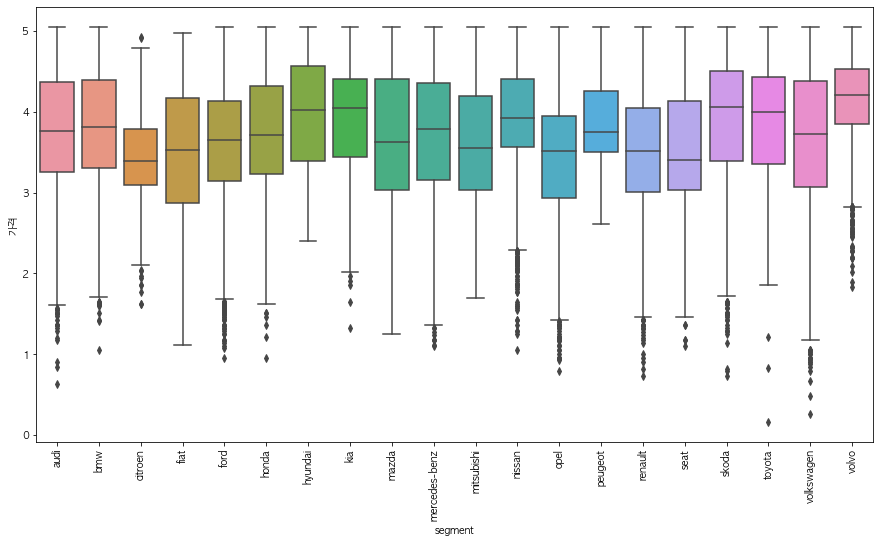

In [57]:
plt.figure(figsize=(15,8))
sns.boxplot(x=train_df9['segment'],y=train_df9['가격'],order=sorted(train_df9.segment.unique()))
plt.xticks(rotation=90)
plt.show()

In [58]:
train_df8.shape[0], train_df9.shape[0]

(57920, 57920)

In [59]:
print(train_df9.shape)
train_df9.head()

(57920, 47)


,생산년도,모델출시년도,차량모델명,판매도시,판매구역,주행거리,배기량,압축천연가스(CNG),경유,가솔린,하이브리드,액화석유가스(LPG),가격,출시년도생산여부,출시이후생산년수,출시이전생산여부,브랜드국적,브랜드대륙명,가스,연료타입,판매도시구역동일여부,production_year_grp,브랜드_Avg,브랜드_Q25,브랜드_Q75,차량모델명_Avg,차량모델명_Q25,차량모델명_Q50,차량모델명_Q75,판매구역_Avg,판매구역_Q25,판매구역_Q50,판매구역_Q75,브랜드_차량모델명_Avg,브랜드_차량모델명_Q25,브랜드_차량모델명_Q50,브랜드_차량모델명_Q75,브랜드_판매구역_Avg,브랜드_판매구역_Q25,브랜드_판매구역_Q50,브랜드_판매구역_Q75,segment,kmeans_label_1,kmeans_label_2,kmeans_label_3,kmeans_label_4,kmeans_label_5
0,0.834442,0.724582,fabia,KAT,SLA,-0.836065,-1.575697,0,0,1,0,0,3.946231,0,0.095535,0,체코,유럽,0,가솔린,0,0,-8.881784e-16,-4.440892e-16,1.776357e-15,-1.289723,-1.257159,-1.352954,-1.324219,0.260894,0.076129,0.219604,0.502768,-1.289723,-1.257159,-1.352954,-1.324219,0.294547,0.453850,-0.080343,0.409862,skoda,0,0,3,0,0
1,-0.613603,-0.752969,auris,RKO,SWI,0.024455,-0.023767,0,0,1,0,0,3.724970,0,0.166189,0,일본,아시아,0,가솔린,0,1,0.000000e+00,8.881784e-16,8.881784e-16,0.345921,0.281534,0.295228,0.040522,-2.006230,-1.017156,-2.241310,-2.735300,0.345921,0.281534,0.295228,0.040522,-0.704950,-0.303903,-1.040675,-1.631444,toyota,1,2,0,2,2
2,-1.143023,-0.562400,clk-klasa,GNI,WIE,0.499560,-0.673600,0,0,1,0,0,2.879760,1,-1.347041,1,독일,유럽,0,가솔린,0,1,0.000000e+00,4.440892e-16,-8.881784e-16,-1.065284,-0.238086,-0.677804,-2.852173,-0.696033,-1.079302,-0.252732,-0.006405,-1.065284,-0.238086,-0.677804,-2.852173,-0.417619,-0.508368,-0.113595,-0.136579,mercedes-benz,0,0,3,0,0
3,-1.476101,-2.086687,x-trail,EHX,WIE,1.591089,2.038881,0,1,0,0,0,2.901422,0,0.739109,0,일본,아시아,0,경유,0,1,0.000000e+00,0.000000e+00,8.881784e-16,0.977428,1.440628,1.526758,1.058689,-0.782043,-1.200983,-0.304308,-0.039559,0.977428,1.440628,1.526758,1.058689,-0.656350,-0.740974,0.127434,-0.383612,nissan,2,1,2,1,3
4,-1.195204,-0.462942,bravo,OSW,MAL,1.710821,2.776681,0,1,0,0,0,2.865054,1,-1.240315,1,이탈리아,유럽,0,경유,0,0,0.000000e+00,0.000000e+00,0.000000e+00,-0.689201,-0.382146,-0.612669,-1.108377,0.184164,0.174178,0.191462,0.003637,-0.689201,-0.382146,-0.612669,-1.108377,0.321677,0.063393,-0.024993,0.881700,fiat,0,0,3,0,0


(2) segment 기준

In [60]:
# outlier_boundary = []
# del_outlier_segment_data_dict = deepcopy(segment_data_dict)
# del_outlier_segment_data_dict['train'] = {}
# del_outlier_segment_data_dict['test']  = {}
# total_n_outlier = 0

# for seg in tqdm(segment_data_dict['segment_list']):
#     check_num_features = [col for col in num_features
#                           if (col.find('_')<0) & (col in segment_data_dict['train'][seg].columns)]
#     check_num_features += [target_feature]
    
#     i=0
#     for col in check_num_features:
#         i+=1
#         outlier_detector = OutlierDetect(
#             target_feature=col,
#             #group='segment',
#         )
#         outlier_detector.fit(
#             data=segment_data_dict['train'][seg],
#             whis=3.0,
#         )
#         tr_d = outlier_detector.transform(data=segment_data_dict['train'][seg],max_example=4,verbose=False)\
#             .reset_index(drop=True,inplace=True)
#         te_d = segment_data_dict['test'][seg].copy()

#         _outlier_boundary = outlier_detector.outlier_boundary.copy()
#         _outlier_boundary.insert(0,'target_feature',col)
#         _outlier_boundary.insert(0,'segment',seg)
        
#         outlier_boundary.append(_outlier_boundary)
#         total_n_outlier += _outlier_boundary.n_outlier.sum()
#         del_outlier_segment_data_dict['train'][seg] = tr_d
#         del_outlier_segment_data_dict['test'] [seg] = te_d
        
# outlier_boundary_df = pd.concat(outlier_boundary,axis=0)

In [61]:
# total_n_outlier, sum([len(value) for key,value in segment_data_dict['train'].items()])

In [62]:
# outlier_boundary_df[outlier_boundary_df.n_outlier!=0].head()

In [63]:
# n_outlier_df = pd.merge(
#     outlier_boundary_df.groupby('segment')['n_outlier'].sum().reset_index(),
#     outlier_boundary_df.groupby('segment')['n_total'].mean().reset_index(),
#     how='left',on='segment',
# )
# n_outlier_df['p_outlier'] = n_outlier_df.n_outlier / n_outlier_df.n_total
# n_outlier_df.sort_values('p_outlier',ascending=False).round(3).head(10)

(3) outlier 처리 하지않음

In [64]:
# del_outlier_segment_data_dict = segment_data_dict

<br></br>

# Memory Reduce

In [65]:
# https://www.kaggle.com/code/arjanso/reducing-dataframe-memory-size-by-65
def reduce_mem_usage(props,verbose=False):
    # Byte -> MB : 2^20
    asis_mem_usg = props.memory_usage().sum() / (2**20)
    NAlist = [] # Keeps track of columns that have missing values filled in. 
    
    num_cols = props.columns[props.dtypes!=object]
    i=0
    total=len(num_cols)
    for col in num_cols:
        i+=1
        asis_dtype = props[col].dtype

        # make variables for Int, max and min
        IsInt = False
        mx = props[col].max()
        mn = props[col].min()

        # Integer does not support NA, therefore, NA needs to be filled
        if not np.isfinite(props[col]).all(): 
            NAlist.append(col)
            props[col].fillna(mn-1,inplace=True)  

        # test if column can be converted to an integer
        asint = props[col].fillna(0).astype(np.int64)
        result = (props[col] - asint)
        result = result.sum()
        if result > -0.01 and result < 0.01:
            IsInt = True

        # Make Integer/unsigned Integer datatypes
        if IsInt:
            if mn >= 0:
                if mx < 255:
                    props[col] = props[col].astype(np.uint8)
                elif mx < 65535:
                    props[col] = props[col].astype(np.uint16)
                elif mx < 4294967295:
                    props[col] = props[col].astype(np.uint32)
                else:
                    props[col] = props[col].astype(np.uint64)
            else:
                if mn > np.iinfo(np.int8).min and mx < np.iinfo(np.int8).max:
                    props[col] = props[col].astype(np.int8)
                elif mn > np.iinfo(np.int16).min and mx < np.iinfo(np.int16).max:
                    props[col] = props[col].astype(np.int16)
                elif mn > np.iinfo(np.int32).min and mx < np.iinfo(np.int32).max:
                    props[col] = props[col].astype(np.int32)
                elif mn > np.iinfo(np.int64).min and mx < np.iinfo(np.int64).max:
                    props[col] = props[col].astype(np.int64)    

        # Make float datatypes 32 bit
        else:
            props[col] = props[col].astype(np.float32)

        tobe_dtype = props[col].dtype
        if verbose:
            text = '[{}/{}] {}: {} -> {}'.format(
                str(i).zfill(len(str(total))),total,col,asis_dtype,tobe_dtype)
            print(text)
    
    # na가 있으면 min-1로 넣었으므로, 이 값들을 다시 nan으로 변경
    for col in NAlist:
        props[col] = props[col].replace(props[col].min(),np.nan)
        
    tobe_mem_usg = props.memory_usage().sum() / (2**20)
    reduced_mem  = 100*tobe_mem_usg/asis_mem_usg
    
    if verbose:
        print('Memory reduced by {:.2f}% ({:.2f} MB → {:.2f} MB)'.format(reduced_mem,asis_mem_usg,tobe_mem_usg))
        
    return props, (asis_mem_usg, tobe_mem_usg, reduced_mem)

(1) 전체 기준

In [66]:
train_df10, _ = reduce_mem_usage(train_df9,verbose=False)
test_df10 , _ = reduce_mem_usage(test_df9 ,verbose=False)

(2) segment 기준

In [67]:
# final_segment_data_dict = deepcopy(del_outlier_segment_data_dict)
# final_segment_data_dict['train'] = {}
# final_segment_data_dict['test']  = {}

# for seg in final_segment_data_dict['segment_list']:
#     final_segment_data_dict['train'][seg], _ = reduce_mem_usage(segment_data_dict['train'][seg],verbose=False)
#     final_segment_data_dict['test'] [seg], _ = reduce_mem_usage(segment_data_dict['test'] [seg],verbose=False)

<br></br>

# Modeling

In [68]:
import os
def mkdir(paths):
    if type(paths)==str:
        paths = [paths]
    for path in paths:
        if not os.path.isdir(path):
            print('> Create Folder: {}'.format(path))
            os.mkdir(path)

In [69]:
def inverse_transform(x,func=['log','sqrt']):
    if func=='log':
        y = np.exp(x)
    elif func=='sqrt':
        y = np.square(x)
    else:
        raise ValueError('Unknown func')
    return y

In [70]:
mkdir('./model_checkpoints')
mkdir('./model_checkpoints/segment_catboost')
mkdir('./model_checkpoints/segment_weightedensemble')

In [71]:
assert train_df10.isnull().sum().sum()==0, \
    "Train: null detected"

assert test_df10.isnull().sum().sum()==0, \
    "Train: null detected"

In [72]:
# assert (sum([v.isnull().sum().sum() for k,v in final_segment_data_dict['train'].items()])==0), \
#     "Train: null detected"

# assert (sum([v.isnull().sum().sum() for k,v in final_segment_data_dict['test'].items()])==0), \
#     "Test: null detected"

<br>

## Check feature importance

In [ ]:
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

In [ ]:
train_fn = train_df10.copy()
test_fn  = test_df10 .copy()

In [ ]:
%%time
# 2분

X = train_fn.drop(target_feature,axis=1)
y = train_fn[target_feature]

X_train, X_val, y_train, y_val = train_test_split(
    X,y,test_size=0.2,random_state=CFG.SEED,stratify=X['segment'])

train_dataset = Pool(X_train,y_train,cat_features=cat_features+['segment'])
val_dataset   = Pool(X_val  ,y_val  ,cat_features=cat_features+['segment'])

model = CatBoostRegressor(iterations=5000)
model.fit(train_dataset,eval_set=val_dataset,metric_period=1000,early_stopping_rounds=100)

In [ ]:
y_pred = model.predict(val_dataset).flatten()
y_true = y_val.values.flatten()

y_pred = inverse_transform(y_pred,CFG.TARGET_TRANSFORMATION)
y_true = inverse_transform(y_true,CFG.TARGET_TRANSFORMATION)

mean_absolute_error(y_true=y_true,y_pred=y_pred)

In [ ]:
feature_importance = model.feature_importances_
sorted_idx = np.argsort(feature_importance)

plt.figure(figsize=(15,10))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_train.columns)[sorted_idx])
plt.title('Feature Importance')
plt.show()

<br>

## CatBoost
- public score : 

In [ ]:
gc.collect()

In [ ]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error
from catboost import CatBoostRegressor, Pool

In [ ]:
train_fn = train_df10.copy()
test_fn  = test_df10 .copy()

In [ ]:
%%time
# 1시간

X = train_fn.drop(target_feature,axis=1)
y = train_fn[target_feature]

segment_list = X['segment'].unique()

models = {}
feature_info = {}
scores = []
pbar = tqdm(segment_list)

s_i = 0
for segment in pbar:
    s_i+=1
    
    # segment에 해당하는 데이터추출
    _X = X[X.segment==segment].drop('segment',axis=1)
    _y = y[X.segment==segment]
    
    # kfold
    kf = KFold(n_splits=CFG.N_SPLITS,random_state=1000*s_i+CFG.SEED,shuffle=True)
    
    # unique인 컬럼 제외
    unique_info = _X.nunique()
    unique_cols = unique_info[unique_info==1].index.tolist()
    if len(unique_cols)>0:
        _X = _X.drop(unique_cols,axis=1)
        
    # categorical feature에서 unique인 컬럼을 제외
    fixed_cat_features = [col for col in cat_features if col in _X.columns]
    
    _models = []
    _scores = []
    k=0
    for tr_idx,val_idx in kf.split(_X,_y):
        k+=1
        
        # kfold dataset
        X_tr, X_va = _X.iloc[tr_idx], _X.iloc[val_idx]
        y_tr, y_va = _y.iloc[tr_idx], _y.iloc[val_idx]

        # progress
        progress = 'Segment: [{}], Size: [{:,}], KFold: [{}/{}]'\
            .format(segment,len(_X),k,CFG.N_SPLITS)
        pbar.set_description(progress)

        # dataset
        train_dataset = Pool(X_tr,y_tr,cat_features=fixed_cat_features)
        valid_dataset = Pool(X_va,y_va,cat_features=fixed_cat_features)

        # define the model
        model = CatBoostRegressor(
            loss_function='MAE',
            random_state=CFG.SEED,
            iterations=CFG.EPOCHS,
            learning_rate=CFG.LR,
            allow_writing_files=False,
        )

        # fit the model
        model.fit(
            train_dataset,
            eval_set=valid_dataset,
            early_stopping_rounds=CFG.ES,
            verbose=0,
            #metric_period=CFG.EPOCHS//5,
        )

        # save the model
        model.save_model(f'./model_checkpoints/segment_catboost/{segment}_k{k}.cbm')

        # prediction
        y_pred = model.predict(valid_dataset).flatten()
        y_true = y_va.values
        
        # inverse transform
        if CFG.TARGET_TRANSFORMATION=='log':
            y_pred = np.exp(y_pred)
            y_true = np.exp(y_true)
        elif CFG.TARGET_TRANSFORMATION=='sqrt':
            y_pred = np.square(y_pred)
            y_true = np.square(y_true)
            
        # calculate score
        score = mean_absolute_error(y_true=y_true,y_pred=y_pred)
        
        # append inner loop
        _models.append(model)
        _scores.append([segment,k,len(X_tr),len(X_va),score])

    # append outer loop
    models[segment] = _models
    scores.append(_scores)
    feature_info[segment] = {'cat_features':fixed_cat_features,'features':_X.columns.tolist()}
    
    # score report
    mean_score_report = pd.Series(np.array(_scores)[:,-1]).astype(float).mean()
    print('Segment: {}'.format(segment))
    print("MAE's for {}-Fold: [{}]".format(CFG.N_SPLITS,np.array(pd.Series(np.array(_scores)[:,-1]).astype(float).values)))
    print("Mean of MAE's for {}-Fold: [{:.4f}]".format(CFG.N_SPLITS,mean_score_report))

In [ ]:
score_df = pd.DataFrame(
    np.array(scores).reshape(len(scores)*5,5),
    columns=['segment','k','n_tr','n_val','score']
)
score_df[['k','n_tr','n_val','score']] = score_df[['k','n_tr','n_val','score']].astype(float)
score_df.sort_values(['segment','k']).head(10)

# score_df.groupby('segment')[['n_tr','n_val','score']].mean().sort_values('score')

In [ ]:
# inference
X = train_fn.drop(target_feature,axis=1)
y = train_fn[target_feature]

X_test = test_fn.copy()

segment_list = X['segment'].unique()

tr_pred_list = []
te_pred_list = []
for segment in tqdm(segment_list):
    ## data load
    # (1) train
    train_data = X[X.segment==segment][feature_info[segment]['features']]
    train_dataset = Pool(train_data,cat_features=feature_info[segment]['cat_features'])
    # (2) test
    test_data = X_test[X_test.segment==segment][feature_info[segment]['features']]
    test_dataset = Pool(test_data,cat_features=feature_info[segment]['cat_features'])
    
    ## model
    kfold_models = models[segment]
    
    ## prediction
    # (1) train
    tr_pred_df = pd.DataFrame({
        'segment':segment,
        'true':y[X.segment==segment].values.flatten(),
        'pred':np.mean([model.predict(train_dataset) for model in kfold_models],axis=0),
        #'pred':np.sum([weight*model.predict(train_dataset) for weight,model in zip(kfold_weights,kfold_models)],axis=0),
    })
    tr_pred_df.index = train_data.index
    # (2) test
    te_pred_df = pd.DataFrame({
        'segment':segment,
        'pred':np.mean([model.predict(test_dataset) for model in kfold_models],axis=0),
        #'pred':np.sum([weight*model.predict(test_dataset) for weight,model in zip(kfold_weights,kfold_models)],axis=0),
    })
    te_pred_df.index = test_data.index
    
    ## Target Transformation
    if CFG.TARGET_TRANSFORMATION=='log':
        tr_pred_df['true'] = np.exp(tr_pred_df['true'])
        tr_pred_df['pred'] = np.exp(tr_pred_df['pred'])
        te_pred_df['pred'] = np.exp(te_pred_df['pred'])
    elif CFG.TARGET_TRANSFORMATION=='sqrt':
        tr_pred_df['true'] = np.square(tr_pred_df['true'])
        tr_pred_df['pred'] = np.square(tr_pred_df['pred'])
        te_pred_df['pred'] = np.square(te_pred_df['pred'])
    
    ## append
    tr_pred_list.append(tr_pred_df)
    te_pred_list.append(te_pred_df)

In [ ]:
# train
tr_pred_df = pd.concat(tr_pred_list,axis=0).sort_index()
mean_absolute_error(y_true=tr_pred_df.true,y_pred=tr_pred_df.pred)

In [ ]:
te_pred_df = pd.concat(te_pred_list,axis=0).sort_index()
te_pred_df.head()

In [ ]:
# a = pd.read_csv('./out/15_ensemble_stacking_segment_브랜드_kfold_logy_interaction_.csv')['가격']
# b = te_pred_df.pred.values

# mean_absolute_error(a,b)

In [ ]:
submit = pd.read_csv('./data/sample_submission.csv')
submit['가격'] = te_pred_df.pred.values
submit.to_csv('./out/19_catboost_segment_브랜드국적_kfold_logy_outlierdetection.csv',index=False)

<br>

## Weighted Ensemble
- public score : 

In [79]:
import pandas as pd
import warnings

class OneHotEncoder:
    def __init__(self):
        pass
    
    def fit(self,data,columns):
        self.transform_list = []
        for col in columns:
            for i,value in enumerate(sorted(data[col].unique())):
                if i>0:
                    self.transform_list.append([col,value])
        
    def transform(self,data):
        warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
        new_data = data.copy()
        for col,value in self.transform_list:
            new_data[f'{col}_{value}'] = np.where(new_data[col]==value,1,0)
        drop_columns = pd.unique(np.array(self.transform_list)[:,0])
        new_data.drop(columns=drop_columns,inplace=True)
        return new_data

In [80]:
from copy import deepcopy
from sklearn.base import BaseEstimator, RegressorMixin
from catboost import CatBoostRegressor, Pool
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.linear_model import LinearRegression, ElasticNetCV
from sklearn.model_selection import RepeatedKFold
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.metrics import mean_absolute_error
import warnings
import time
import pickle

class WeightedEnsembleRegressor(BaseEstimator, RegressorMixin):
    def __init__(self,weight=['equal','balanced'],inverse_transform=None):
        super().__init__()
        
        assert weight in ['equal','balanced'], \
            "weight must be one of ['equal','balanced']"
        
        self.weight = weight
        self.inverse_transform = inverse_transform
        self._get_regressors()
    
    def _get_regressors(self):
        max_depth = 20
        n_jobs = -1
        
        params_elasticnet = {
            'l1_ratio' : np.arange(0.1, 1, 0.1),
            'alphas' : [1e-5, 1e-3, 1e-1, 0.0, 1.0, 10.0, 100.0],
            'cv' : RepeatedKFold(n_splits=CFG.N_SPLITS, n_repeats=3, random_state=CFG.SEED),
            'n_jobs' : n_jobs,
            #'max_iter' : 50000,
            'tol' : 0.001,
        }
        
        params_catboost = {
            'random_state' : CFG.SEED,
            'iterations' : CFG.EPOCHS,
            'early_stopping_rounds' : CFG.ES,
            'learning_rate' : CFG.LR,
            'loss_function' : 'MAE',
            'grow_policy' : 'Lossguide', # 'SymmetricTree','Depthwise'
            'use_best_model' : True,
            'allow_writing_files' : False,
            'verbose' : 0,
            'max_depth' : max_depth,
            #'l2_leaf_reg' : 1,
        }
    
        params_xgboost = {
            'random_state' : CFG.SEED,
            'n_estimators' : CFG.XGB_EPOCHS,
            'early_stopping_rounds' : CFG.XGB_ES,
            'learning_rate' : CFG.XGB_LR,
            'objective' : 'reg:absoluteerror',
            'verbosity' : 0,
            'max_depth': max_depth,
            'n_jobs' : n_jobs,
        }
    
        params_lightgbm = {
            'random_state' : CFG.SEED,
            'n_estimators' : CFG.EPOCHS,
            'early_stopping_round' : CFG.ES,
            'learning_rate' : CFG.LR,
            'objective' : 'regression',
            'metric' : 'mean_absolute_error',
            'verbosity' : -1,
            'max_depth': max_depth,
            'n_jobs' : n_jobs,
        }
        
        params_extratrees = {
            'random_state' : CFG.SEED,
            'n_estimators' : CFG.XTRATREES_EPOCHS,
            'criterion' : 'absolute_error',
            'verbose' : 0,
            'max_depth' : max_depth,
            'n_jobs' : n_jobs,
        }
        
        self.regressors = [
            #LinearRegression(),
            ElasticNetCV(**params_elasticnet),
            CatBoostRegressor(**params_catboost),
            XGBRegressor(**params_xgboost),
            LGBMRegressor(**params_lightgbm),
            #ExtraTreesRegressor(**params_extratrees),
        ]
        self.regressors_name = [
            #'OLS',
            'ElasticNet',
            'CatBoost',
            'XGBoost',
            'LightGBM',
            #'ExtraTrees',
        ]
        
    def _set_zero_to_minimum(self,pred,minimum_value):
        pred = np.array(pred).flatten()
        if np.where(pred<0,1,0).sum()>0:
            pred = [x if x>0 else minimum_value for x in pred]
        pred = np.array(pred).flatten()
        return pred
    
    def _set_inf_to_maximum(self,pred,maximum_value):
        pred = np.array(pred).flatten()
        if np.where(pred==np.inf,1,0).sum()>0:
            pred = [x if x!=np.inf else maximum_value for x in pred]
        pred = np.array(pred).flatten()
        return pred
    
    def fit(self,X,y,eval_set,oh_set,cat_features,verbose=1):
        assert len(eval_set)==1, \
            "eval_set length must be 1. len(eval_set)={}".format(len(eval_set))
        assert len(oh_set)==1, \
            "oh_set length must be 1. len(oh_set)={}".format(len(oh_set))
        X_val, y_val = eval_set[0]
        X_oh, X_val_oh = oh_set[0]
        
        tr_true = np.array(y)    .flatten()
        va_true = np.array(y_val).flatten()
        if self.inverse_transform is not None:
            tr_true = self.inverse_transform(tr_true)
            va_true = self.inverse_transform(va_true)
        
        self.minimum_value = min(np.nanmin(y),np.nanmin(y_val))
        self.maximum_value = max(np.nanmax(y),np.nanmax(y_val))
        
        self.cat_features = cat_features
        self.weights = []
        self.fitting_elapsed = []
        if verbose:
            pbar = tqdm(zip(self.regressors_name,self.regressors),total=len(self.regressors))
        else:
            pbar = zip(self.regressors_name,self.regressors)
            
        fit_iter = 0
        for regressor_name,regressor in pbar:
            fit_iter+=1
            s = time.time()
            
            if verbose:
                pbar.set_description(name)
                
            if regressor_name in ['OLS','ElasticNet']:
                warnings.filterwarnings("ignore", category=UserWarning)
                regressor.fit(X_oh,y)
                tr_pred = regressor.predict(X_oh)
                va_pred = regressor.predict(X_val_oh)
            elif regressor_name=='CatBoost':
                train_dataset = Pool(X,y,cat_features=cat_features)
                val_dataset   = Pool(X_val,y_val,cat_features=cat_features)
                regressor.fit(
                    train_dataset,
                    eval_set=val_dataset,
                    #metric_period=CFG.EPOCHS//5,
                )
                tr_pred = regressor.predict(train_dataset)
                va_pred = regressor.predict(val_dataset)
            elif regressor_name=='XGBoost':
                regressor.fit(
                    X_oh,y,
                    eval_set=[(X_val_oh,y_val)],
                    verbose=0,
                )
                tr_pred = regressor.predict(X_oh)
                va_pred = regressor.predict(X_val_oh)
            elif regressor_name=='LightGBM':
                warnings.filterwarnings("ignore", category=UserWarning)
                X_tmp = X.copy()
                X_val_tmp = X_val.copy()
                for col in cat_features:
                    X_tmp[col]     = X_tmp[col]    .astype('category')
                    X_val_tmp[col] = X_val_tmp[col].astype('category')
                regressor.fit(
                    X_tmp,y,
                    eval_set=[(X_val_tmp,y_val)],
                    verbose=-1,
                )
                tr_pred = regressor.predict(X_tmp)
                va_pred = regressor.predict(X_val_tmp)
            elif regressor_name=='ExtraTrees':
                regressor.fit(X_oh,y)
                tr_pred = regressor.predict(X_oh)
                va_pred = regressor.predict(X_val_oh)
            else:
                raise ValueError('Unknown Regressor: {}'.format(regressor_name))
            
            tr_pred = np.array(tr_pred).flatten()
            va_pred = np.array(va_pred).flatten()
            
            tr_pred = self._set_zero_to_minimum(tr_pred,self.minimum_value)
            va_pred = self._set_zero_to_minimum(va_pred,self.minimum_value)
            
            if self.inverse_transform is not None:
                tr_pred = self.inverse_transform(tr_pred)
                va_pred = self.inverse_transform(va_pred)
                tr_pred = self._set_inf_to_maximum(tr_pred,self.maximum_value)
                va_pred = self._set_inf_to_maximum(va_pred,self.maximum_value)
            
            tr_score = mean_absolute_error(y_pred=tr_pred,y_true=tr_true)
            va_score = mean_absolute_error(y_pred=va_pred,y_true=va_true)
            e = time.time()
            self.weights.append(1/va_score)
            self.fitting_elapsed.append(e-s)
            
            blank = ' '*(11-len(regressor_name))
            fit_progress = '[{}/{}] {}{}: score={:.3f}, val_score={:.3f}, elasped={:.1f}s'\
                .format(fit_iter,len(self.regressors),regressor_name,blank,tr_score,va_score,e-s)
            print(fit_progress)
        
        if self.weight=='equal':
            self.weights = np.array([1.0 for _ in self.regressors])
        self.weights /= sum(self.weights)
        
        tr_pred = self.predict(X,X_oh)
        va_pred = self.predict(X_val,X_val_oh)
        
        ## -> self.predict에서 inverse_transform 해줌
        # if self.inverse_transform is not None:
        #     tr_pred = self.inverse_transform(tr_pred)
        #     va_pred = self.inverse_transform(va_pred)
        
        ens_tr_score = mean_absolute_error(y_true=tr_true,y_pred=tr_pred)
        ens_va_score = mean_absolute_error(y_true=va_true,y_pred=va_pred)
        
        total_fit_progress = 'Weighted Ensemble({}): score={:.3f}, val_score={:.3f}, elasped={:.1f}s'\
            .format(self.weight,ens_tr_score,ens_va_score,sum(self.fitting_elapsed))
        print(total_fit_progress)
        
    def predict(self,X,X_oh):
        assert len(X)==len(X_oh), \
            "X and X_oh must be same length"
        
        pred_list = []
        for regressor_name,regressor in zip(self.regressors_name,self.regressors):
            if regressor_name in ['OLS','ElasticNet','XGBoost','ExtraTrees']:
                dataset = X_oh.copy()
            elif regressor_name=='CatBoost':
                dataset = Pool(X,cat_features=self.cat_features)
            elif regressor_name=='LightGBM':
                dataset = X.copy()
                for col in self.cat_features:
                    dataset[col] = dataset[col].astype('category')
            else:
                raise ValueError('Unknown Regressor: {}'.format(regressor_name))
            
            y_pred = regressor.predict(dataset)
            y_pred = self._set_zero_to_minimum(y_pred,self.minimum_value)
            
            pred_list.append(y_pred)
            
        final_pred = np.zeros(len(X))
        for pred,weight in zip(pred_list,self.weights):
            final_pred += np.array(pred)*weight
            
        if self.inverse_transform is not None:
            final_pred = self.inverse_transform(np.array(final_pred))
            final_pred = self._set_inf_to_maximum(final_pred,self.maximum_value)
            
        return final_pred
    
    def save_model(self,path):
        save_dict = {
            'cat_features' : self.cat_features,
            'weights' : self.weights,
            'fitting_elapsed' : self.fitting_elapsed,
            'regressors' : self.regressors,
        }
        with open(path, 'wb') as f:
            pickle.dump(save_dict, f, protocol=pickle.HIGHEST_PROTOCOL)
            
    def load_model(self,path):
        with open(path, 'rb') as f:
            save_dict = pickle.load(f)
            self.cat_features = save_dict['cat_features']
            self.weights = save_dict['weights']
            self.fitting_elapsed = save_dict['fitting_elapsed']
            self.regressors = save_dict['regressors']

In [81]:
from sklearn.model_selection import KFold

In [82]:
gc.collect()

1603

In [83]:
train_fn = train_df10.copy()
test_fn  = test_df10 .copy()

In [84]:
%%time
# 2시간

X = train_fn.drop(target_feature,axis=1)
y = train_fn[target_feature]

ohe = OneHotEncoder()
ohe.fit(X,cat_features)
X_oh = ohe.transform(X)

segment_list = X['segment'].value_counts().sort_values(ascending=False).index.tolist()

models = {}
feature_info = {}
scores = []

s_i = 0
for segment in tqdm(segment_list):
    s_i+=1
    
    # segment에 해당하는 데이터추출
    _X    = X   [X   .segment==segment].drop('segment',axis=1)
    _X_oh = X_oh[X_oh.segment==segment].drop('segment',axis=1)
    _y    = y   [X   .segment==segment]
    
    # kfold
    kf = KFold(n_splits=CFG.N_SPLITS,random_state=1000*s_i+CFG.SEED,shuffle=True)
    
    # unique인 컬럼 제외
    # (1) X
    unique_info = _X.nunique()
    unique_cols = unique_info[unique_info==1].index.tolist()
    if len(unique_cols)>0:
        _X = _X.drop(unique_cols,axis=1)
    # (2) X_oh
    unique_info = _X_oh.nunique()
    unique_cols = unique_info[unique_info==1].index.tolist()
    if len(unique_cols)>0:
        _X_oh = _X_oh.drop(unique_cols,axis=1)
        
    # categorical feature에서 unique인 컬럼을 제외
    fixed_cat_features = [col for col in cat_features if col in _X.columns]
    
    # progress
    progress = '> [{}/{}] Segment: {}, Length: {}'.format(s_i,len(segment_list),segment,len(_X))
    print('-'*80)
    print(progress)
    print('-'*80)
    
    _models = []
    _scores = []
    k=0
    for tr_idx,val_idx in kf.split(_X,_y):
        k+=1
        print('> [K-Fold] {}/{}'.format(k,CFG.N_SPLITS))
        
        # kfold dataset
        X_tr   , X_va    = _X   .iloc[tr_idx], _X   .iloc[val_idx]
        X_tr_oh, X_va_oh = _X_oh.iloc[tr_idx], _X_oh.iloc[val_idx]
        y_tr   , y_va    = _y   .iloc[tr_idx], _y   .iloc[val_idx]

        # define the model
        ensemble_model = WeightedEnsembleRegressor(
            weight='balanced',
            inverse_transform=lambda x: inverse_transform(x,func=CFG.TARGET_TRANSFORMATION),
        )

        # fit the model
        ensemble_model.fit(
            X_tr,y_tr,
            eval_set=[(X_va,y_va)],
            oh_set=[(X_tr_oh,X_va_oh)],
            cat_features=fixed_cat_features,
            verbose=0,
        )

        # save the model
        ensemble_model.save_model(f'./model_checkpoints/segment_weightedensemble/{segment}_k{k}.pickle')

        # prediction
        y_pred = ensemble_model.predict(X_va,X_va_oh).flatten()
        y_true = y_va.values
        
        # caculate score
        score = mean_absolute_error(y_true=y_true,y_pred=y_pred)
        
        # append inner loop
        _models.append(ensemble_model)
        _scores.append([segment,k,len(X_tr),len(X_va),score])

    # append outer loop
    models[segment] = _models
    scores.append(_scores)
    feature_info[segment] = {
        'cat_features':fixed_cat_features,
        'features':_X.columns.tolist(),
        'oh_features':_X_oh.columns.tolist(),
    }

  0%|          | 0/20 [00:00<?, ?it/s]

--------------------------------------------------------------------------------
> [1/20] Segment: opel, Length: 6651
--------------------------------------------------------------------------------
> [K-Fold] 1/5
[1/4] ElasticNet : score=4.811, val_score=4.779, elasped=48.9s
[2/4] CatBoost   : score=3.084, val_score=3.916, elasped=53.4s
[3/4] XGBoost    : score=0.220, val_score=4.779, elasped=56.8s
[4/4] LightGBM   : score=3.270, val_score=4.134, elasped=20.2s
Weighted Ensemble(balanced): score=2.674, val_score=3.981, elasped=179.3s
> [K-Fold] 2/5
[1/4] ElasticNet : score=4.833, val_score=4.797, elasped=49.3s
[2/4] CatBoost   : score=3.176, val_score=3.854, elasped=44.8s
[3/4] XGBoost    : score=0.241, val_score=4.651, elasped=51.9s
[4/4] LightGBM   : score=3.335, val_score=3.994, elasped=17.2s
Weighted Ensemble(balanced): score=2.716, val_score=3.904, elasped=163.1s
> [K-Fold] 3/5
[1/4] ElasticNet : score=4.814, val_score=4.964, elasped=48.4s
[2/4] CatBoost   : score=3.089, val_score

  5%|▌         | 1/20 [14:03<4:27:05, 843.44s/it]

--------------------------------------------------------------------------------
> [2/20] Segment: ford, Length: 5819
--------------------------------------------------------------------------------
> [K-Fold] 1/5
[1/4] ElasticNet : score=6.033, val_score=6.245, elasped=39.8s
[2/4] CatBoost   : score=4.099, val_score=5.105, elasped=33.5s
[3/4] XGBoost    : score=0.247, val_score=6.134, elasped=48.8s
[4/4] LightGBM   : score=4.072, val_score=5.153, elasped=17.5s
Weighted Ensemble(balanced): score=3.401, val_score=5.169, elasped=139.6s
> [K-Fold] 2/5
[1/4] ElasticNet : score=6.094, val_score=6.552, elasped=39.1s
[2/4] CatBoost   : score=4.218, val_score=5.530, elasped=23.5s
[3/4] XGBoost    : score=0.279, val_score=6.364, elasped=43.9s
[4/4] LightGBM   : score=4.386, val_score=5.622, elasped=13.6s
Weighted Ensemble(balanced): score=3.530, val_score=5.528, elasped=120.1s
> [K-Fold] 3/5
[1/4] ElasticNet : score=6.056, val_score=5.916, elasped=39.7s
[2/4] CatBoost   : score=4.005, val_score

 10%|█         | 2/20 [24:51<3:38:30, 728.38s/it]

Weighted Ensemble(balanced): score=3.504, val_score=5.327, elasped=127.0s
--------------------------------------------------------------------------------
> [3/20] Segment: volkswagen, Length: 5693
--------------------------------------------------------------------------------
> [K-Fold] 1/5
[1/4] ElasticNet : score=7.808, val_score=8.202, elasped=47.1s
[2/4] CatBoost   : score=4.750, val_score=5.960, elasped=39.3s
[3/4] XGBoost    : score=0.327, val_score=7.192, elasped=48.7s
[4/4] LightGBM   : score=5.229, val_score=6.111, elasped=14.8s
Weighted Ensemble(balanced): score=4.155, val_score=6.089, elasped=149.9s
> [K-Fold] 2/5
[1/4] ElasticNet : score=7.909, val_score=7.890, elasped=46.9s
[2/4] CatBoost   : score=4.857, val_score=6.233, elasped=32.3s
[3/4] XGBoost    : score=0.388, val_score=7.247, elasped=47.3s
[4/4] LightGBM   : score=5.347, val_score=6.468, elasped=13.1s
Weighted Ensemble(balanced): score=4.242, val_score=6.295, elasped=139.6s
> [K-Fold] 3/5
[1/4] ElasticNet : score

 15%|█▌        | 3/20 [37:53<3:33:16, 752.74s/it]

--------------------------------------------------------------------------------
> [4/20] Segment: audi, Length: 5597
--------------------------------------------------------------------------------
> [K-Fold] 1/5
[1/4] ElasticNet : score=7.266, val_score=7.464, elasped=53.3s
[2/4] CatBoost   : score=5.109, val_score=6.238, elasped=28.5s
[3/4] XGBoost    : score=0.259, val_score=7.687, elasped=55.8s
[4/4] LightGBM   : score=5.874, val_score=6.702, elasped=10.4s
Weighted Ensemble(balanced): score=4.413, val_score=6.317, elasped=148.0s
> [K-Fold] 2/5
[1/4] ElasticNet : score=7.274, val_score=7.696, elasped=52.6s
[2/4] CatBoost   : score=5.019, val_score=6.419, elasped=31.1s
[3/4] XGBoost    : score=0.305, val_score=7.539, elasped=51.6s
[4/4] LightGBM   : score=5.377, val_score=6.650, elasped=13.3s
Weighted Ensemble(balanced): score=4.235, val_score=6.484, elasped=148.6s
> [K-Fold] 3/5
[1/4] ElasticNet : score=7.359, val_score=7.294, elasped=52.8s
[2/4] CatBoost   : score=4.970, val_score

 20%|██        | 4/20 [51:09<3:25:22, 770.16s/it]

--------------------------------------------------------------------------------
> [5/20] Segment: bmw, Length: 5262
--------------------------------------------------------------------------------
> [K-Fold] 1/5
[1/4] ElasticNet : score=8.939, val_score=8.665, elasped=48.2s
[2/4] CatBoost   : score=6.277, val_score=7.675, elasped=23.5s
[3/4] XGBoost    : score=0.356, val_score=8.682, elasped=41.8s
[4/4] LightGBM   : score=6.072, val_score=7.837, elasped=15.9s
Weighted Ensemble(balanced): score=5.111, val_score=7.620, elasped=129.4s
> [K-Fold] 2/5
[1/4] ElasticNet : score=8.985, val_score=9.172, elasped=47.5s
[2/4] CatBoost   : score=6.230, val_score=7.529, elasped=26.1s
[3/4] XGBoost    : score=0.332, val_score=8.687, elasped=42.1s
[4/4] LightGBM   : score=6.497, val_score=7.710, elasped=12.7s
Weighted Ensemble(balanced): score=5.184, val_score=7.486, elasped=128.4s
> [K-Fold] 3/5
[1/4] ElasticNet : score=8.710, val_score=9.220, elasped=48.2s
[2/4] CatBoost   : score=5.877, val_score=

 25%|██▌       | 5/20 [1:01:59<3:01:39, 726.67s/it]

--------------------------------------------------------------------------------
> [6/20] Segment: renault, Length: 3853
--------------------------------------------------------------------------------
> [K-Fold] 1/5
[1/4] ElasticNet : score=6.464, val_score=6.489, elasped=22.7s
[2/4] CatBoost   : score=3.513, val_score=4.622, elasped=36.1s
[3/4] XGBoost    : score=0.387, val_score=5.503, elasped=23.3s
[4/4] LightGBM   : score=4.005, val_score=4.666, elasped=11.5s
Weighted Ensemble(balanced): score=3.180, val_score=4.637, elasped=93.6s
> [K-Fold] 2/5
[1/4] ElasticNet : score=6.312, val_score=7.127, elasped=22.8s
[2/4] CatBoost   : score=3.510, val_score=5.039, elasped=29.9s
[3/4] XGBoost    : score=0.477, val_score=5.886, elasped=21.8s
[4/4] LightGBM   : score=3.657, val_score=5.163, elasped=16.2s
Weighted Ensemble(balanced): score=3.083, val_score=5.127, elasped=90.7s
> [K-Fold] 3/5
[1/4] ElasticNet : score=6.443, val_score=6.869, elasped=22.6s
[2/4] CatBoost   : score=3.644, val_scor

 30%|███       | 6/20 [1:09:59<2:30:01, 642.94s/it]

Weighted Ensemble(balanced): score=3.118, val_score=4.727, elasped=95.8s
--------------------------------------------------------------------------------
> [7/20] Segment: toyota, Length: 3259
--------------------------------------------------------------------------------
> [K-Fold] 1/5
[1/4] ElasticNet : score=7.076, val_score=6.596, elasped=16.9s
[2/4] CatBoost   : score=3.394, val_score=5.105, elasped=48.1s
[3/4] XGBoost    : score=0.377, val_score=6.300, elasped=19.2s
[4/4] LightGBM   : score=4.022, val_score=5.401, elasped=17.6s
Weighted Ensemble(balanced): score=3.215, val_score=5.227, elasped=101.9s
> [K-Fold] 2/5
[1/4] ElasticNet : score=7.183, val_score=6.034, elasped=17.2s
[2/4] CatBoost   : score=3.888, val_score=4.389, elasped=27.9s
[3/4] XGBoost    : score=0.472, val_score=5.763, elasped=17.0s
[4/4] LightGBM   : score=4.553, val_score=5.023, elasped=14.5s
Weighted Ensemble(balanced): score=3.536, val_score=4.560, elasped=76.6s
> [K-Fold] 3/5
[1/4] ElasticNet : score=6.602

 35%|███▌      | 7/20 [1:16:46<2:02:34, 565.73s/it]

Weighted Ensemble(balanced): score=3.230, val_score=5.490, elasped=76.4s
--------------------------------------------------------------------------------
> [8/20] Segment: skoda, Length: 3130
--------------------------------------------------------------------------------
> [K-Fold] 1/5
[1/4] ElasticNet : score=7.101, val_score=6.707, elasped=12.4s
[2/4] CatBoost   : score=4.648, val_score=5.913, elasped=30.2s
[3/4] XGBoost    : score=0.423, val_score=7.153, elasped=19.7s
[4/4] LightGBM   : score=5.370, val_score=6.042, elasped=11.0s
Weighted Ensemble(balanced): score=4.183, val_score=5.862, elasped=73.3s
> [K-Fold] 2/5
[1/4] ElasticNet : score=6.994, val_score=6.843, elasped=12.2s
[2/4] CatBoost   : score=4.710, val_score=6.033, elasped=30.1s
[3/4] XGBoost    : score=0.389, val_score=7.838, elasped=21.7s
[4/4] LightGBM   : score=5.053, val_score=6.374, elasped=12.8s
Weighted Ensemble(balanced): score=4.156, val_score=6.121, elasped=76.8s
> [K-Fold] 3/5
[1/4] ElasticNet : score=6.959, 

 40%|████      | 8/20 [1:23:00<1:40:57, 504.76s/it]

--------------------------------------------------------------------------------
> [9/20] Segment: mercedes-benz, Length: 2899
--------------------------------------------------------------------------------
> [K-Fold] 1/5
[1/4] ElasticNet : score=10.889, val_score=10.455, elasped=21.9s
[2/4] CatBoost   : score=5.450, val_score=7.654, elasped=28.8s
[3/4] XGBoost    : score=0.351, val_score=9.171, elasped=19.7s
[4/4] LightGBM   : score=6.396, val_score=8.102, elasped=12.4s
Weighted Ensemble(balanced): score=5.172, val_score=7.824, elasped=82.7s
> [K-Fold] 2/5
[1/4] ElasticNet : score=10.819, val_score=10.056, elasped=22.0s
[2/4] CatBoost   : score=5.735, val_score=8.088, elasped=22.3s
[3/4] XGBoost    : score=0.341, val_score=9.556, elasped=19.5s
[4/4] LightGBM   : score=6.828, val_score=8.515, elasped=10.1s
Weighted Ensemble(balanced): score=5.385, val_score=8.108, elasped=73.9s
> [K-Fold] 3/5
[1/4] ElasticNet : score=10.548, val_score=10.444, elasped=21.8s
[2/4] CatBoost   : score=5.1

 45%|████▌     | 9/20 [1:30:09<1:28:09, 480.88s/it]

Weighted Ensemble(balanced): score=4.848, val_score=9.451, elasped=76.2s
--------------------------------------------------------------------------------
> [10/20] Segment: nissan, Length: 2129
--------------------------------------------------------------------------------
> [K-Fold] 1/5
[1/4] ElasticNet : score=5.399, val_score=5.777, elasped=10.6s
[2/4] CatBoost   : score=3.534, val_score=4.897, elasped=24.0s
[3/4] XGBoost    : score=0.356, val_score=6.258, elasped=13.5s
[4/4] LightGBM   : score=3.995, val_score=5.439, elasped=10.6s
Weighted Ensemble(balanced): score=3.149, val_score=5.039, elasped=58.7s
> [K-Fold] 2/5
[1/4] ElasticNet : score=5.520, val_score=5.483, elasped=10.6s
[2/4] CatBoost   : score=3.757, val_score=5.022, elasped=16.2s
[3/4] XGBoost    : score=0.357, val_score=6.138, elasped=12.8s
[4/4] LightGBM   : score=3.765, val_score=5.525, elasped=12.9s
Weighted Ensemble(balanced): score=3.192, val_score=5.047, elasped=52.6s
> [K-Fold] 3/5
[1/4] ElasticNet : score=5.578

 50%|█████     | 10/20 [1:34:45<1:09:38, 417.85s/it]

--------------------------------------------------------------------------------
> [11/20] Segment: kia, Length: 2034
--------------------------------------------------------------------------------
> [K-Fold] 1/5
[1/4] ElasticNet : score=7.768, val_score=7.957, elasped=9.1s
[2/4] CatBoost   : score=4.194, val_score=5.394, elasped=20.1s
[3/4] XGBoost    : score=0.489, val_score=7.172, elasped=14.1s
[4/4] LightGBM   : score=4.770, val_score=5.915, elasped=10.2s
Weighted Ensemble(balanced): score=3.825, val_score=5.666, elasped=53.6s
> [K-Fold] 2/5
[1/4] ElasticNet : score=7.793, val_score=7.966, elasped=9.0s
[2/4] CatBoost   : score=4.166, val_score=5.401, elasped=19.7s
[3/4] XGBoost    : score=0.533, val_score=6.870, elasped=11.9s
[4/4] LightGBM   : score=4.589, val_score=5.596, elasped=12.5s
Weighted Ensemble(balanced): score=3.747, val_score=5.684, elasped=53.1s
> [K-Fold] 3/5
[1/4] ElasticNet : score=7.606, val_score=7.975, elasped=8.8s
[2/4] CatBoost   : score=3.972, val_score=5.83

 55%|█████▌    | 11/20 [1:38:51<54:45, 365.04s/it]  

--------------------------------------------------------------------------------
> [12/20] Segment: hyundai, Length: 1855
--------------------------------------------------------------------------------
> [K-Fold] 1/5
[1/4] ElasticNet : score=6.419, val_score=6.407, elasped=7.4s
[2/4] CatBoost   : score=3.604, val_score=5.117, elasped=39.2s
[3/4] XGBoost    : score=0.661, val_score=6.238, elasped=8.0s
[4/4] LightGBM   : score=3.639, val_score=5.197, elasped=16.2s
Weighted Ensemble(balanced): score=3.245, val_score=5.223, elasped=70.7s
> [K-Fold] 2/5
[1/4] ElasticNet : score=6.599, val_score=6.683, elasped=7.0s
[2/4] CatBoost   : score=3.856, val_score=5.482, elasped=27.2s
[3/4] XGBoost    : score=0.510, val_score=6.321, elasped=8.5s
[4/4] LightGBM   : score=4.639, val_score=5.568, elasped=8.7s
Weighted Ensemble(balanced): score=3.562, val_score=5.453, elasped=51.4s
> [K-Fold] 3/5
[1/4] ElasticNet : score=6.758, val_score=6.315, elasped=7.0s
[2/4] CatBoost   : score=4.243, val_score=5.4

 60%|██████    | 12/20 [1:43:18<44:42, 335.29s/it]

--------------------------------------------------------------------------------
> [13/20] Segment: seat, Length: 1628
--------------------------------------------------------------------------------
> [K-Fold] 1/5
[1/4] ElasticNet : score=5.086, val_score=5.921, elasped=8.7s
[2/4] CatBoost   : score=3.466, val_score=5.394, elasped=13.6s
[3/4] XGBoost    : score=0.345, val_score=6.247, elasped=10.2s
[4/4] LightGBM   : score=3.957, val_score=5.844, elasped=8.4s
Weighted Ensemble(balanced): score=3.058, val_score=5.419, elasped=40.9s
> [K-Fold] 2/5
[1/4] ElasticNet : score=5.104, val_score=5.740, elasped=8.4s
[2/4] CatBoost   : score=3.112, val_score=5.073, elasped=24.7s
[3/4] XGBoost    : score=0.316, val_score=6.319, elasped=10.0s
[4/4] LightGBM   : score=3.417, val_score=5.072, elasped=10.9s
Weighted Ensemble(balanced): score=2.855, val_score=5.128, elasped=54.0s
> [K-Fold] 3/5
[1/4] ElasticNet : score=5.426, val_score=4.602, elasped=8.4s
[2/4] CatBoost   : score=3.183, val_score=4.29

 65%|██████▌   | 13/20 [1:47:38<36:27, 312.56s/it]

--------------------------------------------------------------------------------
> [14/20] Segment: mazda, Length: 1572
--------------------------------------------------------------------------------
> [K-Fold] 1/5
[1/4] ElasticNet : score=7.538, val_score=8.389, elasped=7.1s
[2/4] CatBoost   : score=4.009, val_score=6.313, elasped=16.3s
[3/4] XGBoost    : score=0.599, val_score=7.329, elasped=8.1s
[4/4] LightGBM   : score=3.642, val_score=6.307, elasped=14.2s
Weighted Ensemble(balanced): score=3.407, val_score=6.371, elasped=45.7s
> [K-Fold] 2/5
[1/4] ElasticNet : score=7.792, val_score=7.819, elasped=6.9s
[2/4] CatBoost   : score=4.346, val_score=6.313, elasped=11.3s
[3/4] XGBoost    : score=1.533, val_score=7.230, elasped=7.7s
[4/4] LightGBM   : score=4.458, val_score=6.534, elasped=9.7s
Weighted Ensemble(balanced): score=3.923, val_score=6.277, elasped=35.6s
> [K-Fold] 3/5
[1/4] ElasticNet : score=7.648, val_score=8.137, elasped=7.0s
[2/4] CatBoost   : score=4.576, val_score=4.856

 70%|███████   | 14/20 [1:51:08<28:09, 281.51s/it]

--------------------------------------------------------------------------------
> [15/20] Segment: honda, Length: 1545
--------------------------------------------------------------------------------
> [K-Fold] 1/5
[1/4] ElasticNet : score=6.948, val_score=7.179, elasped=6.9s
[2/4] CatBoost   : score=3.065, val_score=4.917, elasped=28.0s
[3/4] XGBoost    : score=0.295, val_score=6.142, elasped=9.9s
[4/4] LightGBM   : score=4.239, val_score=5.465, elasped=9.7s
Weighted Ensemble(balanced): score=3.109, val_score=5.220, elasped=54.5s
> [K-Fold] 2/5
[1/4] ElasticNet : score=6.852, val_score=6.586, elasped=6.8s
[2/4] CatBoost   : score=3.313, val_score=5.012, elasped=25.1s
[3/4] XGBoost    : score=0.301, val_score=6.429, elasped=9.6s
[4/4] LightGBM   : score=3.978, val_score=5.232, elasped=12.9s
Weighted Ensemble(balanced): score=3.196, val_score=5.255, elasped=54.4s
> [K-Fold] 3/5
[1/4] ElasticNet : score=6.701, val_score=7.307, elasped=6.7s
[2/4] CatBoost   : score=3.513, val_score=5.429

 75%|███████▌  | 15/20 [1:55:15<22:35, 271.07s/it]

--------------------------------------------------------------------------------
> [16/20] Segment: volvo, Length: 1352
--------------------------------------------------------------------------------
> [K-Fold] 1/5
[1/4] ElasticNet : score=8.732, val_score=9.427, elasped=6.7s
[2/4] CatBoost   : score=5.040, val_score=8.514, elasped=21.3s
[3/4] XGBoost    : score=0.432, val_score=8.951, elasped=8.2s
[4/4] LightGBM   : score=4.252, val_score=8.625, elasped=16.3s
Weighted Ensemble(balanced): score=4.187, val_score=8.165, elasped=52.5s
> [K-Fold] 2/5
[1/4] ElasticNet : score=8.421, val_score=9.484, elasped=6.5s
[2/4] CatBoost   : score=5.082, val_score=8.876, elasped=16.5s
[3/4] XGBoost    : score=0.489, val_score=10.379, elasped=7.8s
[4/4] LightGBM   : score=5.431, val_score=9.189, elasped=10.4s
Weighted Ensemble(balanced): score=4.612, val_score=8.821, elasped=41.2s
> [K-Fold] 3/5
[1/4] ElasticNet : score=8.766, val_score=8.870, elasped=6.5s
[2/4] CatBoost   : score=5.036, val_score=7.2

 80%|████████  | 16/20 [1:59:04<17:14, 258.59s/it]

--------------------------------------------------------------------------------
> [17/20] Segment: fiat, Length: 1164
--------------------------------------------------------------------------------
> [K-Fold] 1/5
[1/4] ElasticNet : score=5.603, val_score=6.609, elasped=4.5s
[2/4] CatBoost   : score=3.453, val_score=4.890, elasped=15.8s
[3/4] XGBoost    : score=0.896, val_score=5.745, elasped=6.8s
[4/4] LightGBM   : score=3.061, val_score=5.146, elasped=12.8s
Weighted Ensemble(balanced): score=2.956, val_score=4.997, elasped=39.9s
> [K-Fold] 2/5
[1/4] ElasticNet : score=5.716, val_score=6.638, elasped=4.4s
[2/4] CatBoost   : score=3.491, val_score=5.611, elasped=12.7s
[3/4] XGBoost    : score=0.817, val_score=6.272, elasped=6.6s
[4/4] LightGBM   : score=2.898, val_score=5.533, elasped=14.1s
Weighted Ensemble(balanced): score=2.942, val_score=5.588, elasped=37.8s
> [K-Fold] 3/5
[1/4] ElasticNet : score=5.756, val_score=5.610, elasped=4.4s
[2/4] CatBoost   : score=4.364, val_score=4.766

 85%|████████▌ | 17/20 [2:02:21<11:59, 239.91s/it]

[4/4] LightGBM   : score=3.719, val_score=4.401, elasped=9.7s
Weighted Ensemble(balanced): score=3.346, val_score=4.452, elasped=32.2s
--------------------------------------------------------------------------------
> [18/20] Segment: citroen, Length: 1129
--------------------------------------------------------------------------------
> [K-Fold] 1/5
[1/4] ElasticNet : score=3.853, val_score=4.216, elasped=5.0s
[2/4] CatBoost   : score=2.896, val_score=4.049, elasped=11.7s
[3/4] XGBoost    : score=0.332, val_score=4.709, elasped=6.3s
[4/4] LightGBM   : score=3.201, val_score=4.218, elasped=7.3s
Weighted Ensemble(balanced): score=2.472, val_score=3.999, elasped=30.3s
> [K-Fold] 2/5
[1/4] ElasticNet : score=4.060, val_score=4.068, elasped=5.3s
[2/4] CatBoost   : score=2.647, val_score=4.024, elasped=15.0s
[3/4] XGBoost    : score=0.227, val_score=4.827, elasped=6.7s
[4/4] LightGBM   : score=2.628, val_score=4.206, elasped=9.7s
Weighted Ensemble(balanced): score=2.314, val_score=4.030, el

 90%|█████████ | 18/20 [2:05:33<07:30, 225.41s/it]

Weighted Ensemble(balanced): score=2.422, val_score=3.851, elasped=37.2s
--------------------------------------------------------------------------------
> [19/20] Segment: peugeot, Length: 793
--------------------------------------------------------------------------------
> [K-Fold] 1/5
[1/4] ElasticNet : score=5.965, val_score=5.413, elasped=3.3s
[2/4] CatBoost   : score=3.682, val_score=5.408, elasped=13.1s
[3/4] XGBoost    : score=1.236, val_score=6.688, elasped=5.1s
[4/4] LightGBM   : score=4.918, val_score=5.401, elasped=6.0s
Weighted Ensemble(balanced): score=3.845, val_score=5.190, elasped=27.5s
> [K-Fold] 2/5
[1/4] ElasticNet : score=5.495, val_score=6.558, elasped=3.2s
[2/4] CatBoost   : score=3.428, val_score=5.977, elasped=15.2s
[3/4] XGBoost    : score=0.254, val_score=7.035, elasped=6.5s
[4/4] LightGBM   : score=4.006, val_score=6.210, elasped=7.8s
Weighted Ensemble(balanced): score=3.161, val_score=5.982, elasped=32.7s
> [K-Fold] 3/5
[1/4] ElasticNet : score=5.728, val_

 95%|█████████▌| 19/20 [2:07:58<03:21, 201.49s/it]

[4/4] LightGBM   : score=4.089, val_score=5.694, elasped=7.7s
Weighted Ensemble(balanced): score=3.373, val_score=5.604, elasped=25.3s
--------------------------------------------------------------------------------
> [20/20] Segment: mitsubishi, Length: 556
--------------------------------------------------------------------------------
> [K-Fold] 1/5
[1/4] ElasticNet : score=6.137, val_score=6.726, elasped=2.5s
[2/4] CatBoost   : score=4.456, val_score=6.090, elasped=8.1s
[3/4] XGBoost    : score=0.616, val_score=8.049, elasped=4.7s
[4/4] LightGBM   : score=5.305, val_score=6.614, elasped=3.8s
Weighted Ensemble(balanced): score=3.881, val_score=5.928, elasped=19.2s
> [K-Fold] 2/5
[1/4] ElasticNet : score=5.901, val_score=7.463, elasped=2.6s
[2/4] CatBoost   : score=3.820, val_score=5.857, elasped=12.2s
[3/4] XGBoost    : score=1.427, val_score=7.880, elasped=4.0s
[4/4] LightGBM   : score=4.577, val_score=6.428, elasped=4.7s
Weighted Ensemble(balanced): score=3.630, val_score=6.129, e

100%|██████████| 20/20 [2:09:48<00:00, 389.44s/it]

[4/4] LightGBM   : score=3.402, val_score=7.466, elasped=8.7s
Weighted Ensemble(balanced): score=3.237, val_score=6.648, elasped=26.9s
CPU times: user 9h 12min 18s, sys: 1h 26min 29s, total: 10h 38min 48s
Wall time: 2h 10min 1s


In [85]:
# inference
X = train_fn.drop(target_feature,axis=1)
y = train_fn[target_feature]

X_test = test_fn.copy()

ohe = OneHotEncoder()
ohe.fit(X,cat_features)
X_oh = ohe.transform(X)
X_test_oh = ohe.transform(X_test)

segment_list = X['segment'].unique()

tr_pred_list = []
te_pred_list = []
for segment in tqdm(segment_list):
    ## data load
    # (1) train
    train_data    = X   [X   .segment==segment][feature_info[segment]['features']]
    train_data_oh = X_oh[X_oh.segment==segment][feature_info[segment]['oh_features']]
    # (2) test
    test_data     = X_test   [X_test   .segment==segment][feature_info[segment]['features']]
    test_data_oh  = X_test_oh[X_test_oh.segment==segment][feature_info[segment]['oh_features']]
    
    ## model
    kfold_models = models[segment]
    
    ## prediction
    # (1) train
    tr_pred_df = pd.DataFrame({
        'true':y[X.segment==segment].values.flatten(),
    })
    for i in range(len(kfold_models)):
        tr_pred_df[f'pred_{i+1}'] = kfold_models[i].predict(train_data,train_data_oh)
    tr_pred_df.index = train_data.index
    # (2) test
    te_pred_df = pd.DataFrame()
    for i in range(len(kfold_models)):
        te_pred_df[f'pred_{i+1}'] = kfold_models[i].predict(test_data,test_data_oh)
    te_pred_df.index = test_data.index
        
    ## target transformation
    if CFG.TARGET_TRANSFORMATION=='log':
        tr_pred_df['true'] = np.exp(tr_pred_df['true'])
    elif CFG.TARGET_TRANSFORMATION=='sqrt':
        tr_pred_df['true'] = np.square(tr_pred_df['true'])
    
    ## append
    tr_pred_list.append(tr_pred_df)
    te_pred_list.append(te_pred_df)

100%|██████████| 20/20 [00:40<00:00,  2.04s/it]


In [86]:
# train
tr_pred_df = pd.concat(tr_pred_list,axis=0).sort_index()
te_pred_df = pd.concat(te_pred_list,axis=0).sort_index()

In [87]:
y_pred = tr_pred_df.drop('true',axis=1).apply(lambda x: np.nanmean(x), axis=1)
y_true = tr_pred_df.true

mean_absolute_error(y_pred=y_pred,y_true=y_true)

4.112328692036364

In [88]:
tr_pred_df.to_parquet('./out/stacking/tr_pred_df_segment브랜드_ensemble_logy_생산년도그룹추가.parquet')
te_pred_df.to_parquet('./out/stacking/te_pred_df_segment브랜드_ensemble_logy_생산년도그룹추가.parquet')

In [89]:
tr_pred_df.to_csv('./out/stacking/tr_pred_df_segment브랜드_ensemble_logy_생산년도그룹추가.csv',index=False)
te_pred_df.to_csv('./out/stacking/te_pred_df_segment브랜드_ensemble_logy_생산년도그룹추가.csv',index=False)

<br></br>

## Stacking

<br>

(2) ensemble regressor : 5.6123244492	

In [90]:
# inference
X = train_fn.drop(target_feature,axis=1)
y = train_fn[target_feature]

X_test = test_fn.copy()

segment_list = X['segment'].unique()

# add predictions
X      = pd.concat([X     ,tr_pred_df.drop('true',axis=1)],axis=1)
X_test = pd.concat([X_test,te_pred_df],axis=1)

In [91]:
%%time
# 30분

stacking_models = {}
stacking_feature_info = {}
stacking_scores = []
pbar = tqdm(segment_list)

s_i = 0
for segment in pbar:
    s_i+=1
    
    # segment에 해당하는 데이터추출
    _X = X[X.segment==segment].drop('segment',axis=1)
    _y = y[X.segment==segment]
    
    # kfold
    kf = KFold(n_splits=CFG.N_SPLITS,random_state=1000*s_i+CFG.SEED,shuffle=True)
    
    # unique인 컬럼 제외
    unique_info = _X.nunique()
    unique_cols = unique_info[unique_info==1].index.tolist()
    if len(unique_cols)>0:
        _X = _X.drop(unique_cols,axis=1)
        
    # categorical feature에서 unique인 컬럼을 제외
    fixed_cat_features = [col for col in cat_features if col in _X.columns]
    
    _models = []
    _scores = []
    k=0
    for tr_idx,val_idx in kf.split(_X,_y):
        k+=1
        
        # kfold dataset
        X_tr, X_va = _X.iloc[tr_idx], _X.iloc[val_idx]
        y_tr, y_va = _y.iloc[tr_idx], _y.iloc[val_idx]

        # progress
        progress = 'Segment: [{}], Size: [{:,}], KFold: [{}/{}]'\
            .format(segment,len(_X),k,CFG.N_SPLITS)
        pbar.set_description(progress)

        # dataset
        train_dataset = Pool(X_tr,y_tr,cat_features=fixed_cat_features)
        valid_dataset = Pool(X_va,y_va,cat_features=fixed_cat_features)

        # define the model
        model = CatBoostRegressor(
            loss_function='MAE',
            random_state=CFG.SEED,
            iterations=CFG.EPOCHS,
            learning_rate=CFG.LR,
            allow_writing_files=False,
        )

        # fit the model
        model.fit(
            train_dataset,
            eval_set=valid_dataset,
            early_stopping_rounds=CFG.ES,
            verbose=0,
            #metric_period=CFG.EPOCHS//5,
        )

        # save the model
        model.save_model(f'./model_checkpoints/stacking_segment_catboost/{segment}_k{k}.cbm')

        # prediction
        y_pred = model.predict(valid_dataset).flatten()
        y_true = y_va.values
        
        # inverse transform
        if CFG.TARGET_TRANSFORMATION=='log':
            y_pred = np.exp(y_pred)
            y_true = np.exp(y_true)
        elif CFG.TARGET_TRANSFORMATION=='sqrt':
            y_pred = np.square(y_pred)
            y_true = np.square(y_true)  
            
        # calculate score
        score = mean_absolute_error(y_true=y_true,y_pred=y_pred)
        
        # append inner loop
        _models.append(model)
        _scores.append([segment,k,len(X_tr),len(X_va),score])

    # append outer loop
    stacking_models[segment] = _models
    stacking_scores.append(_scores)
    stacking_feature_info[segment] = {'cat_features':fixed_cat_features,'features':_X.columns.tolist()}
    
    # score report
    mean_score_report = pd.Series(np.array(_scores)[:,-1]).astype(float).mean()
    print('Segment: {}'.format(segment))
    print("MAE's for {}-Fold: [{}]".format(CFG.N_SPLITS,np.array(pd.Series(np.array(_scores)[:,-1]).astype(float).values)))
    print("Mean of MAE's for {}-Fold: [{:.4f}]".format(CFG.N_SPLITS,mean_score_report))

Segment: [toyota], Size: [3,259], KFold: [1/5]:   5%|▌         | 1/20 [02:26<46:13, 145.99s/it]

Segment: skoda
MAE's for 5-Fold: [[4.58211266 4.32519129 4.22602574 4.43213665 4.43267745]]
Mean of MAE's for 5-Fold: [4.3996]


Segment: [mercedes-benz], Size: [2,899], KFold: [1/5]:  10%|█         | 2/20 [03:31<29:37, 98.77s/it]

Segment: toyota
MAE's for 5-Fold: [[3.83137055 3.61935808 3.47040726 3.63737297 3.27115981]]
Mean of MAE's for 5-Fold: [3.5659]


Segment: [nissan], Size: [2,129], KFold: [1/5]:  15%|█▌        | 3/20 [05:06<27:30, 97.09s/it]       

Segment: mercedes-benz
MAE's for 5-Fold: [[4.8540329  4.94278376 5.19427465 5.27209726 5.20974366]]
Mean of MAE's for 5-Fold: [5.0946]


Segment: [fiat], Size: [1,164], KFold: [1/5]:  20%|██        | 4/20 [06:01<21:23, 80.22s/it]  

Segment: nissan
MAE's for 5-Fold: [[3.89879227 3.63796318 3.41109701 3.32296868 3.64856329]]
Mean of MAE's for 5-Fold: [3.5839]


Segment: [audi], Size: [5,597], KFold: [1/5]:  25%|██▌       | 5/20 [06:52<17:24, 69.62s/it]

Segment: fiat
MAE's for 5-Fold: [[3.37430096 3.61138005 4.19158216 3.3674241  2.85165367]]
Mean of MAE's for 5-Fold: [3.4793]


Segment: [renault], Size: [3,853], KFold: [1/5]:  30%|███       | 6/20 [15:57<54:00, 231.47s/it]

Segment: audi
MAE's for 5-Fold: [[3.99685914 4.15231004 4.07985167 4.24002503 4.24339972]]
Mean of MAE's for 5-Fold: [4.1425]


Segment: [volkswagen], Size: [5,693], KFold: [1/5]:  35%|███▌      | 7/20 [19:07<47:10, 217.71s/it]

Segment: renault
MAE's for 5-Fold: [[3.20854428 3.24833747 2.99740724 3.38530949 3.07898581]]
Mean of MAE's for 5-Fold: [3.1837]


Segment: [citroen], Size: [1,129], KFold: [1/5]:  40%|████      | 8/20 [28:41<1:06:15, 331.30s/it]   

Segment: volkswagen
MAE's for 5-Fold: [[4.08881895 3.91201984 3.8938824  4.0971481  4.03471107]]
Mean of MAE's for 5-Fold: [4.0053]


Segment: [bmw], Size: [5,262], KFold: [1/5]:  45%|████▌     | 9/20 [29:32<44:38, 243.54s/it]      

Segment: citroen
MAE's for 5-Fold: [[2.46928743 2.91454541 2.71851171 2.56593269 2.71621609]]
Mean of MAE's for 5-Fold: [2.6769]


Segment: [opel], Size: [6,651], KFold: [1/5]:  50%|█████     | 10/20 [38:18<55:07, 330.76s/it]

Segment: bmw
MAE's for 5-Fold: [[5.00876833 5.01555329 4.68781818 4.93407392 4.57125492]]
Mean of MAE's for 5-Fold: [4.8435]


Segment: [ford], Size: [5,819], KFold: [1/5]:  55%|█████▌    | 11/20 [49:51<1:06:15, 441.71s/it]

Segment: opel
MAE's for 5-Fold: [[2.57244226 2.51950919 2.72156943 2.72175716 2.65963808]]
Mean of MAE's for 5-Fold: [2.6390]


Segment: [mazda], Size: [1,572], KFold: [1/5]:  60%|██████    | 12/20 [55:52<55:36, 417.03s/it] 

Segment: ford
MAE's for 5-Fold: [[3.53213057 3.32477989 3.48383453 3.29223144 3.40021377]]
Mean of MAE's for 5-Fold: [3.4066]


Segment: [honda], Size: [1,545], KFold: [1/5]:  65%|██████▌   | 13/20 [56:45<35:49, 307.02s/it]

Segment: mazda
MAE's for 5-Fold: [[4.19846577 4.06533295 4.31467897 3.75275259 3.52796701]]
Mean of MAE's for 5-Fold: [3.9718]


Segment: [kia], Size: [2,034], KFold: [1/5]:  70%|███████   | 14/20 [57:39<23:02, 230.47s/it]  

Segment: honda
MAE's for 5-Fold: [[3.47372497 3.54687175 3.90232206 3.88542102 3.44955876]]
Mean of MAE's for 5-Fold: [3.6516]


Segment: [seat], Size: [1,628], KFold: [1/5]:  75%|███████▌  | 15/20 [58:36<14:51, 178.22s/it]

Segment: kia
MAE's for 5-Fold: [[3.6809378  3.87468741 4.07951006 4.25335316 4.19370807]]
Mean of MAE's for 5-Fold: [4.0164]


Segment: [volvo], Size: [1,352], KFold: [1/5]:  80%|████████  | 16/20 [59:30<09:23, 140.88s/it]

Segment: seat
MAE's for 5-Fold: [[3.60563572 3.49900815 3.12056846 2.83352525 3.35841234]]
Mean of MAE's for 5-Fold: [3.2834]


Segment: [peugeot], Size: [793], KFold: [1/5]:  85%|████████▌ | 17/20 [1:00:36<05:55, 118.38s/it]

Segment: volvo
MAE's for 5-Fold: [[5.26963135 4.81972966 4.61560329 4.75165206 5.19969306]]
Mean of MAE's for 5-Fold: [4.9313]


Segment: [hyundai], Size: [1,855], KFold: [1/5]:  90%|█████████ | 18/20 [1:01:17<03:10, 95.17s/it]

Segment: peugeot
MAE's for 5-Fold: [[3.63223131 3.43740778 4.2467007  3.93131248 4.47639346]]
Mean of MAE's for 5-Fold: [3.9448]


Segment: [mitsubishi], Size: [556], KFold: [1/5]:  95%|█████████▌| 19/20 [1:02:27<01:27, 87.41s/it]

Segment: hyundai
MAE's for 5-Fold: [[3.50046839 3.46615533 3.65586885 3.87018201 3.61033314]]
Mean of MAE's for 5-Fold: [3.6206]


Segment: [mitsubishi], Size: [556], KFold: [5/5]: 100%|██████████| 20/20 [1:02:47<00:00, 188.38s/it]

Segment: mitsubishi
MAE's for 5-Fold: [[4.50530418 4.55979612 4.06448474 4.07434564 5.5065899 ]]
Mean of MAE's for 5-Fold: [4.5421]
CPU times: user 2h 56min 6s, sys: 32min 14s, total: 3h 28min 21s
Wall time: 1h 2min 47s


In [92]:
score_df = pd.DataFrame(
    np.array(stacking_scores).reshape(len(stacking_scores)*5,5),
    columns=['segment','k','n_tr','n_val','score']
)

score_df.sort_values(['segment','k']).head(10)

,segment,k,n_tr,n_val,score
25,audi,1,4477,1120,3.9968591440949304
26,audi,2,4477,1120,4.152310038919081
27,audi,3,4478,1119,4.0798516746000315
28,audi,4,4478,1119,4.240025027830573
29,audi,5,4478,1119,4.243399716849233
45,bmw,1,4209,1053,5.008768326082391
46,bmw,2,4209,1053,5.0155532874967435
47,bmw,3,4210,1052,4.687818184464053
48,bmw,4,4210,1052,4.934073916244526
49,bmw,5,4210,1052,4.571254922338987


In [93]:
# inference
X = train_fn.drop(target_feature,axis=1)
y = train_fn[target_feature]

X_test = test_fn.copy()

segment_list = X['segment'].unique()

# add predictions
X      = pd.concat([X     ,tr_pred_df.drop('true',axis=1)],axis=1)
X_test = pd.concat([X_test,te_pred_df],axis=1)

In [94]:
tr_pred_list = []
te_pred_list = []
for segment in tqdm(segment_list):
    ## data load
    # (1) train
    train_data = X[X.segment==segment][stacking_feature_info[segment]['features']]
    train_dataset = Pool(train_data,cat_features=stacking_feature_info[segment]['cat_features'])
    # (2) test
    test_data = X_test[X_test.segment==segment][stacking_feature_info[segment]['features']]
    test_dataset = Pool(test_data,cat_features=stacking_feature_info[segment]['cat_features'])
    
    ## model
    kfold_models  = stacking_models[segment]
    kfold_weights = 1 / score_df[score_df.segment==segment].score.astype(float).values
    kfold_weights /= sum(kfold_weights)
    
    ## prediction
    # (1) train
    tr_pred_df = pd.DataFrame({
        'segment':segment,
        'true':y[X.segment==segment].values.flatten(),
        'pred':np.mean([model.predict(train_dataset) for model in kfold_models],axis=0),
        #'pred':np.sum([weight*model.predict(train_dataset) for weight,model in zip(kfold_weights,kfold_models)],axis=0),
    })
    tr_pred_df.index = train_data.index
    # (2) test
    te_pred_df = pd.DataFrame({
        'segment':segment,
        'pred':np.mean([model.predict(test_dataset) for model in kfold_models],axis=0),
        #'pred':np.sum([weight*model.predict(test_dataset) for weight,model in zip(kfold_weights,kfold_models)],axis=0),
    })
    te_pred_df.index = test_data.index
    
    ## Target Transformation
    if CFG.TARGET_TRANSFORMATION=='log':
        tr_pred_df['true'] = np.exp(tr_pred_df['true'])
        tr_pred_df['pred'] = np.exp(tr_pred_df['pred'])
        te_pred_df['pred'] = np.exp(te_pred_df['pred'])
    elif CFG.TARGET_TRANSFORMATION=='sqrt':
        tr_pred_df['true'] = np.square(tr_pred_df['true'])
        tr_pred_df['pred'] = np.square(tr_pred_df['pred'])
        te_pred_df['pred'] = np.square(te_pred_df['pred'])
    
    ## append
    tr_pred_list.append(tr_pred_df)
    te_pred_list.append(te_pred_df)

100%|██████████| 20/20 [00:05<00:00,  3.36it/s]


In [95]:
# train
tr_pred_df = pd.concat(tr_pred_list,axis=0).sort_index()
mean_absolute_error(y_true=tr_pred_df.true,y_pred=tr_pred_df.pred)

2.9440042678915885

In [96]:
te_pred_df = pd.concat(te_pred_list,axis=0).sort_index()
te_pred_df.head()

,segment,pred
0,mazda,84.017686
1,ford,26.242305
2,volkswagen,89.279281
3,renault,124.612841
4,volvo,46.610112


In [97]:
submit = pd.read_csv('./data/sample_submission.csv')
submit['가격'] = te_pred_df.pred.values
submit.to_csv('./out/23_ensemble_stacking_segment_브랜드_kfold_logy_생산년도그룹추가.csv',index=False)

In [100]:
a = submit['가격']
b = pd.read_csv('./out/16_ensemble_stacking_segment_브랜드_kfold_logy.csv')['가격']

mean_absolute_error(a,b), np.sqrt(sum((a-b)**2))

(1.4021331971233975, 288.93457550394487)

In [ ]:
# from pycaret import regression

# d = pd.concat([X_tr,y_tr],axis=1).head()

# regression.setup(
#     data=d,
#     target='가격',
#     remove_outliers=False,
#     verbose=True,
#     normalize=False,
#     feature_selection=False,
#     session_id=0,
#     categorical_features=fixed_cat_features,
# )
# best = regression.compare_models(n_select=5,fold=3,sort='MAE')
# # best

# preds = np.array([regression.predict_model(b,X_va)['prediction_label'].values.flatten() for b in best])
# preds = np.mean(preds,axis=0)
# preds.shape

# mean_absolute_error(y_true=np.exp(y_va.values.flatten()),y_pred=np.exp(preds))